# Project 3: Web APIs & Classification

### Contents

- [Configurations and Libraries](#Configurations-and-Libraries)
- [Functions](#Functions)


- [Scape or Import Data](#Scape-or-Import-Data)
- [Inspect and Clean Data](#Inspect-and-Clean-Data)
- [Output Clean Data](#Output-Clean-Data)


- [EDA](#EDA)


- [Create Feature Matrix and Target](#Create-Feature-Matrix-and-Target)
- [Baseline Model](#Baseline-Model)
- [Logistic Regression Model](#Logistic-Regression-Model)
- [Bayes Classifer](#Bayes-Classifer)
- [Models by Pipeline](#Models-by-Pipeline)


- [Sentiment Analysis](#Sentiment-Analysis)
- [Output Model Predictions](#Output-Model-Predictions)
- [Descriptive and Inferential Statistics](#Descriptive-and-Inferential-Statistics)


- [Outside Research](#Outside-Research)
- [Executive Summary](#Executive-Summary)

### Configurations and Libraries

In [1]:
# user configuration

# True: scape data from website -> save as json files
# False: load json files
scape_data = False

# scape data for subreddits[0] if scape_data=True
scape_index = 0
# scape data for subreddits[1] if scape_data=True
#scape_index = 1

num_requests = 50
posts_limit = 900

subreddits = ['boardgames','mobilegames']
url = "https://www.reddit.com/r/"
headers = {'User-agent':'Bleep blorp bot 0.1'}

In [2]:
# import libraries

# maths
import scipy.stats as stats
import numpy as np
import pandas as pd
#from pandas.api.types import is_numeric_dtype

# visual
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
%matplotlib inline

# modelling
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score,mean_squared_error,confusion_matrix,accuracy_score
from sklearn.pipeline import make_pipeline

# nlp
from sklearn.feature_extraction.text import CountVectorizer,HashingVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import spacy
from spacy.tokens import Doc
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# web
import requests
import json
from IPython.display import Image
from IPython.core.display import HTML

# others
import time
import datetime as dt
import re
import os

In [3]:
# file paths

input_path = '../data/input/'
mid_path = '../data/mid/'
output_path = '../data/output/'

image_path = '../images/'

### Functions

In [4]:
# output scaped data to json files
def write_json_files(data):    
    
    timestamp = dt.datetime.now()
    timestamp = timestamp.strftime(" %Y_%m_%d %H_%M_%S")
    
    filepath = input_path + subreddits[scape_index] + '/'
    filename = subreddits[scape_index] + timestamp + '.json'
    
    if not os.path.exists(filepath):
        os.makedirs(filepath)
    
    file = open(filepath + filename,"w+")    
    json.dump(data,file)
    
    print('created',filename)

In [5]:
# create posts list from json files
def read_json_files(subreddit):   
    
    files = []    
    filepath = input_path + subreddit

    # r=root, d=directories, f = files
    for r, d, f in os.walk(filepath):
        for file in f:
            if '.json' in file:
                files.append(os.path.join(r, file))
                
    posts = []

    # load in newer jsons first
    for f in files[::-1]:
        print(f)
        file_data = open(f).read()
        json_data = json.loads(file_data)

        posts.extend(json_data['data']['children'])
        after = json_data['data']['after']
        
    return posts

In [6]:
# created df with posts

def create_df(posts,df):

    for idx,p in enumerate(posts):

        p_keys = p['data'].keys()

        for col in cols:

            if col in p_keys:
                df.at[idx,col] = p['data'][col]
            else:
                df.at[idx,col] = np.nan
                print(idx,col,'nan')
                
    return df

In [7]:
# Reference: https://towardsdatascience.com/the-real-world-as-seen-on-twitter-sentiment-analysis-part-one-5ac2d06b63fb

wnl = WordNetLemmatizer()

def clean_text(text):
    
    print(text)    
    text = text.lower() # To lowercase    
    text = re.sub(r'\&\w*;', '', text) # Remove HTML special entities (e.g. &amp;)        
    text = re.sub(r'\s\s+', ' ', text) # Remove whitespace (including new line characters)        
    text = re.sub(r'https?:\/\/.*\/\w*', '', text) # Remove hyperlinks 
    print(text)
    
    words = text.split()
    #print(words)
    
    words_2 = []

    for word in words: 
        word_2 = wnl.lemmatize(word)
        #if word != word_2:
            #print(word,word_2)
        words_2.append(word_2)      

    output = ' '.join(words_2)
    print(output)
    return output 

In [8]:
# for sentiment analysis

sentiment_analyzer = SentimentIntensityAnalyzer()

def polarity_scores(doc):
    return sentiment_analyzer.polarity_scores(doc.text)

Doc.set_extension('polarity_scores', getter=polarity_scores) 
nlp = spacy.load('en')

### Scape or Import Data

In [9]:
# get json_data with multiple requests

if scape_data == True:

    posts = []
    after = None

    for i in range(1,num_requests+1):

        if after == None:
            params = {}
        else:
            params = {'after':after}

        json_url = url + subreddits[scape_index] + '.json'
        response = requests.get(json_url,params=params,headers=headers)

        if response.status_code == 200:       

            print('process request',i)

            json_data = response.json()
            posts.extend(json_data['data']['children'])
            after = json_data['data']['after']

            # save scaped data to files
            write_json_files(json_data)        

        else:
            print(response.status_code)
            break

        time.sleep(2)

In [10]:
# load json data from files (saved previously in input folder)

if scape_data == False:
    
    posts_a = read_json_files(subreddits[0])
    posts_b = read_json_files(subreddits[1])      

../data/input/boardgames\boardgames 2019_07_19 21_42_59.json
../data/input/boardgames\boardgames 2019_07_19 21_42_56.json
../data/input/boardgames\boardgames 2019_07_19 21_42_53.json
../data/input/boardgames\boardgames 2019_07_19 21_42_50.json
../data/input/boardgames\boardgames 2019_07_19 21_42_48.json
../data/input/boardgames\boardgames 2019_07_19 21_42_45.json
../data/input/boardgames\boardgames 2019_07_19 21_42_42.json
../data/input/boardgames\boardgames 2019_07_19 21_42_39.json
../data/input/boardgames\boardgames 2019_07_19 21_42_36.json
../data/input/boardgames\boardgames 2019_07_19 21_42_32.json
../data/input/boardgames\boardgames 2019_07_19 21_42_29.json
../data/input/boardgames\boardgames 2019_07_19 21_42_27.json
../data/input/boardgames\boardgames 2019_07_19 21_42_24.json
../data/input/boardgames\boardgames 2019_07_19 21_42_21.json
../data/input/boardgames\boardgames 2019_07_19 21_42_18.json
../data/input/boardgames\boardgames 2019_07_19 21_42_15.json
../data/input/boardgames

../data/input/mobilegames\mobilegames 2019_07_19 21_38_03.json
../data/input/mobilegames\mobilegames 2019_07_19 21_38_01.json
../data/input/mobilegames\mobilegames 2019_07_19 21_37_58.json
../data/input/mobilegames\mobilegames 2019_07_19 21_37_56.json
../data/input/mobilegames\mobilegames 2019_07_19 21_37_53.json
../data/input/mobilegames\mobilegames 2019_07_19 21_37_51.json
../data/input/mobilegames\mobilegames 2019_07_19 21_37_48.json
../data/input/mobilegames\mobilegames 2019_07_19 21_37_46.json
../data/input/mobilegames\mobilegames 2019_07_17 20_17_16.json
../data/input/mobilegames\mobilegames 2019_07_17 20_17_12.json
../data/input/mobilegames\mobilegames 2019_07_17 20_17_09.json
../data/input/mobilegames\mobilegames 2019_07_17 20_17_05.json
../data/input/mobilegames\mobilegames 2019_07_17 20_17_02.json
../data/input/mobilegames\mobilegames 2019_07_17 20_16_58.json
../data/input/mobilegames\mobilegames 2019_07_17 20_16_54.json
../data/input/mobilegames\mobilegames 2019_07_17 20_16_

In [11]:
# posts count info

if scape_data == False:
    
    total_posts_a = len(posts_a)
    unique_posts_a = len(set(p['data']['name'] for p in posts_a))
    total_posts_b = len(posts_b)
    unique_post_b = len(set(p['data']['name'] for p in posts_b))
    
    print('total number of posts:',total_posts_a)
    print('unique number of posts:',unique_posts_a)
    print('')
    print('total number of posts:',total_posts_b)
    print('unique number of posts:',unique_post_b)

total number of posts: 2235
unique number of posts: 1165

total number of posts: 2204
unique number of posts: 956


### Inspect and Clean Data

In [12]:
# create empty df

#cols = list(posts_a[0]['data'].keys())
cols = ['name','title','score','selftext']

df = pd.DataFrame(columns=cols)
df_a = pd.DataFrame(columns=cols)
df_b = pd.DataFrame(columns=cols)

In [13]:
# convert posts to df

df_a = create_df(posts_a,df_a)
df_b = create_df(posts_b,df_b)

In [14]:
# remove rows with duplicated name

print(len(df_a))
print(len(df_b))
print("")

df_a.drop_duplicates(subset='name',inplace=True)
df_b.drop_duplicates(subset='name',inplace=True)

print(len(df_a))
print(len(df_b))

2235
2204

1165
956


In [15]:
df_a.head()

,name,title,score,selftext
0,t3_ccwwo2,What player mats look like after lamination,12,http://imgur.com/gallery/Ab1Q9CQ\n\nSearched t...
1,t3_ccppxz,Anyone playing in downtown Toronto?,69,I've built up a small game collection lately -...
2,t3_ccqzz1,I made an app to help run my PitchCar tourname...,46,
3,t3_ccwwjl,Pandemic Legacy s1 *September spoilers*,8,Just want to make sure cause this seems weird....
4,t3_cctvi9,Rumbleslam is the best game I almost never hea...,17,https://imgur.com/a/tPFXI9B\n\nI think I gloss...


In [16]:
# list all columns

print(df_a.columns)

Index(['name', 'title', 'score', 'selftext'], dtype='object')


In [17]:
# output 1st 5 records

df_a.head()

,name,title,score,selftext
0,t3_ccwwo2,What player mats look like after lamination,12,http://imgur.com/gallery/Ab1Q9CQ\n\nSearched t...
1,t3_ccppxz,Anyone playing in downtown Toronto?,69,I've built up a small game collection lately -...
2,t3_ccqzz1,I made an app to help run my PitchCar tourname...,46,
3,t3_ccwwjl,Pandemic Legacy s1 *September spoilers*,8,Just want to make sure cause this seems weird....
4,t3_cctvi9,Rumbleslam is the best game I almost never hea...,17,https://imgur.com/a/tPFXI9B\n\nI think I gloss...


In [18]:
# df_a summary

df_a_desc = df_a.describe()
df_a_desc

,name,title,score,selftext
count,1165,1165,1165,1165
unique,1165,1165,202,987
top,t3_c5pxsv,How to keep sleeved cards from sliding all over?,0,
freq,1,1,76,137


In [19]:
# Check for nulls in columns

null_cols = df_a.isnull().sum()
mask_null = null_cols > 0
null_cols[mask_null].sort_values(ascending=False)

Series([], dtype: int64)

In [20]:
# Check for nulls in rows

null_rows = df_a.isnull().sum(axis=1)
mask_null = null_rows > 0
null_rows[mask_null].sort_values(ascending=False)

Series([], dtype: int64)

In [21]:
# show column summary

df_a_info = df_a.info()
df_a_info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1165 entries, 0 to 2178
Data columns (total 4 columns):
name        1165 non-null object
title       1165 non-null object
score       1165 non-null object
selftext    1165 non-null object
dtypes: object(4)
memory usage: 45.5+ KB


In [22]:
# limit no of rows in each df

df_a = df_a[:posts_limit]
df_b = df_b[:posts_limit]

In [23]:
df_a['title'] = df_a['title'].apply(clean_text)
df_b['title'] = df_b['title'].apply(clean_text)

df_a['selftext'] = df_a['selftext'].apply(clean_text)
df_b['selftext'] = df_b['selftext'].apply(clean_text)

What player mats look like after lamination
what player mats look like after lamination
what player mat look like after lamination
Anyone playing in downtown Toronto?
anyone playing in downtown toronto?
anyone playing in downtown toronto?
I made an app to help run my PitchCar tournaments. I've used it with other games and hope others find it useful, too!
i made an app to help run my pitchcar tournaments. i've used it with other games and hope others find it useful, too!
i made an app to help run my pitchcar tournaments. i've used it with other game and hope others find it useful, too!
Pandemic Legacy s1 *September spoilers*
pandemic legacy s1 *september spoilers*
pandemic legacy s1 *september spoilers*
Rumbleslam is the best game I almost never heard of
rumbleslam is the best game i almost never heard of
rumbleslam is the best game i almost never heard of
About to play eldritch horror for the first time. Tips?
about to play eldritch horror for the first time. tips?
about to play eldrit

my boyfriend proposed to me with custom-printed gloomhaven cards 3
my boyfriend proposed to me with custom-printed gloomhaven card 3
Red Dragon Inn Complete List??
red dragon inn complete list??
red dragon inn complete list??
I recently made a Discord server, dedicated to digital version of Small World 2
i recently made a discord server, dedicated to digital version of small world 2
i recently made a discord server, dedicated to digital version of small world 2
City of Kings is very fun, until it suddenly isn't.
city of kings is very fun, until it suddenly isn't.
city of king is very fun, until it suddenly isn't.
The deceitful player
the deceitful player
the deceitful player
Looking for a pirate game from childhood
looking for a pirate game from childhood
looking for a pirate game from childhood
Kickstarter Roundup: Jul 14, 2019 | 11 Ending Soon (including: ROLL PLAYER - Fiends &amp; Familiars Expansion) &amp; 42 New This Week (including: Trial By Trolley)
kickstarter roundup: jul 14, 

i made an android app to keep track of game list and board game price changes. i'm looking for some feedback on the first version
Trying to remember a game
trying to remember a game
trying to remember a game
Root expansions?
root expansions?
root expansions?
Train Tuesday - (July 16, 2019)
train tuesday - (july 16, 2019)
train tuesday - (july 16, 2019)
Pitch a game Idea
pitch a game idea
pitch a game idea
Pandemic... too easy?
pandemic... too easy?
pandemic... too easy?
Help an idiot
help an idiot
help an idiot
For those of you that don't own a gaming table, do you use a special mat or table cloth?
for those of you that don't own a gaming table, do you use a special mat or table cloth?
for those of you that don't own a gaming table, do you use a special mat or table cloth?
Using lazy Susan’s for board game play
using lazy susan’s for board game play
using lazy susan’s for board game play
DYI Gaming Table for less than $50
dyi gaming table for less than $50
dyi gaming table for le than 

7th Continent Extra Kickstarter copies now available (USA)
7th continent extra kickstarter copies now available (usa)
7th continent extra kickstarter copy now available (usa)
One-Player Wednesday - (July 17, 2019)
one-player wednesday - (july 17, 2019)
one-player wednesday - (july 17, 2019)
Table Of Ultimate Gaming - warped boards
table of ultimate gaming - warped boards
table of ultimate gaming - warped board
Memoir 44 Breakthrough Board - How much should I spend?
memoir 44 breakthrough board - how much should i spend?
memoir 44 breakthrough board - how much should i spend?
Looking what to buy: Is LOTR: Journeys in Middle earth like Descent?
looking what to buy: is lotr: journeys in middle earth like descent?
looking what to buy: is lotr: journey in middle earth like descent?
Thoughts on Homeland: The Game
thoughts on homeland: the game
thought on homeland: the game
Any tips for Robinson Crusoe?
any tips for robinson crusoe?
any tip for robinson crusoe?
Battles of Westeros: Fantasy Fl

Developer Diary for Werewolf vs. Vampire 3
developer diary for werewolf vs. vampire 3
developer diary for werewolf vs. vampire 3
7 Wonders Basic Strategy = Grab Blue Cards?
7 wonders basic strategy = grab blue cards?
7 wonder basic strategy = grab blue cards?
Has anyone ever gone to a secondhand store and bought board games just because you wanted/needed certain pieces in that game?
has anyone ever gone to a secondhand store and bought board games just because you wanted/needed certain pieces in that game?
ha anyone ever gone to a secondhand store and bought board game just because you wanted/needed certain piece in that game?
Is it really possible to have multiple CCGs and the like in your life?
is it really possible to have multiple ccgs and the like in your life?
is it really possible to have multiple ccgs and the like in your life?
7th continent questions
7th continent questions
7th continent question
Best way to get into Advanced Squad Leader (ASL)?
best way to get into advanced s

are we just stupid or is it this hard? [pandemic legacy s2]
are we just stupid or is it this hard? [pandemic legacy s2]
How Many Meeple? An app to help you find games to play
how many meeple? an app to help you find games to play
how many meeple? an app to help you find game to play
Card game-‘Varsh’
card game-‘varsh’
card game-‘varsh’
[Trailer] Teburu: A New Evolution in Board Games
[trailer] teburu: a new evolution in board games
[trailer] teburu: a new evolution in board game
Kingdom Sketch Part 2 - in which our buddy draws out Kingdom Death Campaign
kingdom sketch part 2 - in which our buddy draws out kingdom death campaign
kingdom sketch part 2 - in which our buddy draw out kingdom death campaign
How often do you purchase games on average?
how often do you purchase games on average?
how often do you purchase game on average?
CMON and IDW making a Dragon Ball miniatures game!
cmon and idw making a dragon ball miniatures game!
cmon and idw making a dragon ball miniature game!
Are th

/r/boardgames daily discussion and game recommendation (june 28, 2019)
Actualol: The 10 Best Party Games of 2018
actualol: the 10 best party games of 2018
actualol: the 10 best party game of 2018
Impressions of Fast Forward FORTUNE - another fun Friedemann Friese title
impressions of fast forward fortune - another fun friedemann friese title
impression of fast forward fortune - another fun friedemann friese title
What is your "white whale" game? Mine: A solo auction game.
what is your "white whale" game? mine: a solo auction game.
what is your "white whale" game? mine: a solo auction game.
Gateway games, gatekeeping, and complexity snobbery
gateway games, gatekeeping, and complexity snobbery
gateway games, gatekeeping, and complexity snobbery
Highlighting a Few New Kickstarter Guidelines – Stonemaier Games
highlighting a few new kickstarter guidelines – stonemaier games
highlighting a few new kickstarter guideline – stonemaier game
Question about Root: did the patch improve the Lizard 

Q&amp;A - Please help me know the title of the game
qa - please help me know the title of the game
qa - please help me know the title of the game
PUSH availability
push availability
push availability
Defective Complots 2 set
defective complots 2 set
defective complots 2 set
Pandemic rule check
pandemic rule check
pandemic rule check
What Is the Game Quinns Shows At the End of the New SUSD Video???
what is the game quinns shows at the end of the new susd video???
what is the game quinns show at the end of the new susd video???
/r/boardgames Daily Discussion and Game Recommendations (June 29, 2019)
/r/boardgames daily discussion and game recommendations (june 29, 2019)
/r/boardgames daily discussion and game recommendation (june 29, 2019)
Best card sleeves to write on?
best card sleeves to write on?
best card sleeve to write on?
Cosmic encounter ship replacement
cosmic encounter ship replacement
cosmic encounter ship replacement
An interview with the creator of the Final Fantasy Tactics 

made a laser cut insert set for memoir 44
Color pedestals for minis
color pedestals for minis
color pedestal for mini
Tabletop Simulator group!
tabletop simulator group!
tabletop simulator group!
where to buy Dungeon Saga
where to buy dungeon saga
where to buy dungeon saga
Today's puzzle: Can you get 32+ points following these rules in Carcassonne?
today's puzzle: can you get 32+ points following these rules in carcassonne?
today's puzzle: can you get 32+ point following these rule in carcassonne?
Need help remembering strategy card game
need help remembering strategy card game
need help remembering strategy card game
What is the minimum number of times you'd like to see a board game played for a review?
what is the minimum number of times you'd like to see a board game played for a review?
what is the minimum number of time you'd like to see a board game played for a review?
Ghost Stories 2.0 first pics. It's called Last Bastion.
ghost stories 2.0 first pics. it's called last bastion.

Card printing
card printing
card printing
Square game cards - feeling odd or does it matter at all?
square game cards - feeling odd or does it matter at all?
square game card - feeling odd or doe it matter at all?
Heavy games - how many times do you actually play
heavy games - how many times do you actually play
heavy game - how many time do you actually play
An Interview with Sandy Petersen, the Man Behind Doom, Cthulhu Wars, Eternal Adversary, Plus More
an interview with sandy petersen, the man behind doom, cthulhu wars, eternal adversary, plus more
an interview with sandy petersen, the man behind doom, cthulhu wars, eternal adversary, plus more
The Monthly Board Game Bazaar - (July, 2019)
the monthly board game bazaar - (july, 2019)
the monthly board game bazaar - (july, 2019)
I'm going to Calgary soon! What are the best stores and where can I get a reasonably priced crokinole board?
i'm going to calgary soon! what are the best stores and where can i get a reasonably priced crokinol

quacks of quendlinburg and player count...why not 6?
quack of quendlinburg and player count...why not 6?
Thunderstone Quest - Issues with latest Kickstarter
thunderstone quest - issues with latest kickstarter
thunderstone quest - issue with latest kickstarter
Halfway through the year, what currently stands as your game of 2019 so far?
halfway through the year, what currently stands as your game of 2019 so far?
halfway through the year, what currently stand a your game of 2019 so far?
If Scythe had a faction for every alternate history country, what would the country's faction mat be like?
if scythe had a faction for every alternate history country, what would the country's faction mat be like?
if scythe had a faction for every alternate history country, what would the country's faction mat be like?
What are the best board game component upgrades?
what are the best board game component upgrades?
what are the best board game component upgrades?
First Impression of Root (and what I think 

we battle to become the strongest champion a we review thunderstone quest. video is time stamped
What's the name of the mechanic where you take things off your player board to reveal resources that you get in later turns?
what's the name of the mechanic where you take things off your player board to reveal resources that you get in later turns?
what's the name of the mechanic where you take thing off your player board to reveal resource that you get in later turns?
Questions about Middara and Gloomhaven
questions about middara and gloomhaven
question about middara and gloomhaven
Any of you guys came up with board game ideas but never had enough courage to make it to the Kickstarter?
any of you guys came up with board game ideas but never had enough courage to make it to the kickstarter?
any of you guy came up with board game idea but never had enough courage to make it to the kickstarter?
/r/boardgames Daily Discussion and Game Recommendations (July 04, 2019)
/r/boardgames daily discus

i made a variant to the great dalmuti. would love to hear your thought on it. it involves the jester of death and the jester of good fortune. thinking about calling it the greatest dalmuti.
How much have you spent on this hobby?
how much have you spent on this hobby?
how much have you spent on this hobby?
Abstract starting player fix
abstract starting player fix
abstract starting player fix
Moving my collection from EU to Asia
moving my collection from eu to asia
moving my collection from eu to asia
Valeria: Card Kingdoms - Should I Play? - How to Play &amp; Review - TL:DW in Comments
valeria: card kingdoms - should i play? - how to play review - tl:dw in comments
valeria: card kingdom - should i play? - how to play review - tl:dw in comment
Time Stories
time stories
time story
Forgotten Favorites Friday - (July 05, 2019)
forgotten favorites friday - (july 05, 2019)
forgotten favorite friday - (july 05, 2019)
My 7th continent all-in bundle came in. Can anyone with experience explain so

looking for someone to create a custom board game?
looking for someone to create a custom board game?
[COMC] A little over a year of collecting and really getting into it!
[comc] a little over a year of collecting and really getting into it!
[comc] a little over a year of collecting and really getting into it!
My issue with Star Wars: Rebellion
my issue with star wars: rebellion
my issue with star wars: rebellion
As a new player; how do you decide what games to purchase?
as a new player; how do you decide what games to purchase?
a a new player; how do you decide what game to purchase?
[COMC] For the first time in 4 years into the hobby I decided to see all of my collection in one place.
[comc] for the first time in 4 years into the hobby i decided to see all of my collection in one place.
[comc] for the first time in 4 year into the hobby i decided to see all of my collection in one place.
Gaming in Hong Kong
gaming in hong kong
gaming in hong kong
Excited for game night!
excited for g

How do you make your PnP copies?
how do you make your pnp copies?
how do you make your pnp copies?
Let's discuss: Gipf Project!
let's discuss: gipf project!
let's discuss: gipf project!
Is there anywhere to pre-order CMON's Cthulhu: Death May Die in New Zealand?
is there anywhere to pre-order cmon's cthulhu: death may die in new zealand?
is there anywhere to pre-order cmon's cthulhu: death may die in new zealand?
Food Chain Magnate 3p: always an island
food chain magnate 3p: always an island
food chain magnate 3p: always an island
How to keep sleeved cards from sliding all over?
how to keep sleeved cards from sliding all over?
how to keep sleeved card from sliding all over?
Azul First Round Scoring Question
azul first round scoring question
azul first round scoring question
Price fluctuations
price fluctuations
price fluctuation
Maybe someone here can help find the name of this deckbuilder with player specific markets
maybe someone here can help find the name of this deckbuilder with p

odd question about the "reselient population" card verbiage in pandemic
Peurto Rico most optimal move in first round
peurto rico most optimal move in first round
peurto rico most optimal move in first round
Does anyone know what the 29th pic down game is? It’s 3 pics under the hat with chips pic and it looks really cool with the orb thing.
does anyone know what the 29th pic down game is? it’s 3 pics under the hat with chips pic and it looks really cool with the orb thing.
doe anyone know what the 29th pic down game is? it’s 3 pic under the hat with chip pic and it look really cool with the orb thing.
[COMC] My boardgame collection is choking out my liquor collection!
[comc] my boardgame collection is choking out my liquor collection!
[comc] my boardgame collection is choking out my liquor collection!
Quest for El Dorado - New edition announced!
quest for el dorado - new edition announced!
quest for el dorado - new edition announced!
Looking for a game
looking for a game
looking for a g

Viable Marvel Legendary Storage?
viable marvel legendary storage?
viable marvel legendary storage?
War of the Ring is a great game! So, I made a great 'how to play' series for it.
war of the ring is a great game! so, i made a great 'how to play' series for it.
war of the ring is a great game! so, i made a great 'how to play' series for it.
Extending Two Rooms and a Boom with Resistance power cards?
extending two rooms and a boom with resistance power cards?
extending two room and a boom with resistance power cards?
How much was 7th continent KS All-in Gameplay with Shipping to Australia?
how much was 7th continent ks all-in gameplay with shipping to australia?
how much wa 7th continent k all-in gameplay with shipping to australia?
Card Sleeve Testing Kits
card sleeve testing kits
card sleeve testing kit
Listing Trade Condition on BGG
listing trade condition on bgg
listing trade condition on bgg
Auto-Chess/Underlords/Teamfight Tactics - Would it work as a board game?
auto-chess/underlor

Group buy Kickstarter
group buy kickstarter
group buy kickstarter
Gloomhaven storage.
gloomhaven storage.
gloomhaven storage.
Thoughts on "I would fight the Dragon"?
thoughts on "i would fight the dragon"?
thought on "i would fight the dragon"?
I’m looking for a board game and thought you guys could help
i’m looking for a board game and thought you guys could help
i’m looking for a board game and thought you guy could help
Help me find this board game (please!)
help me find this board game (please!)
help me find this board game (please!)
I designed some Pandemic two-player scorecards.
i designed some pandemic two-player scorecards.
i designed some pandemic two-player scorecards.
Possible Fake Copy of Root: The Riverfolk Purchased
possible fake copy of root: the riverfolk purchased
possible fake copy of root: the riverfolk purchased
7th Continent vs Etherfields
7th continent vs etherfields
7th continent v etherfields
game toppers 2.0
game toppers 2.0
game topper 2.0
Trying to remember t

trailer park boys mobile game reviews. smokes let’s go.
trailer park boy mobile game reviews. smoke let’s go.
The best strategy game on mobile plz get this video to 50 likes
the best strategy game on mobile plz get this video to 50 likes
the best strategy game on mobile plz get this video to 50 like
Interesting??...
interesting??...
interesting??...
Any Pinoy Gamer here in Mobile ? Looking for a Fun Game! Let's Play FreeStyle Mobile PH
any pinoy gamer here in mobile ? looking for a fun game! let's play freestyle mobile ph
any pinoy gamer here in mobile ? looking for a fun game! let's play freestyle mobile ph
BORED
bored
bored
need help finding a game
need help finding a game
need help finding a game
Gs gamessoft race #coming #soon
gs gamessoft race #coming #soon
g gamessoft race #coming #soon
Mobile gaming
mobile gaming
mobile gaming
Help on finding this mobile game?
help on finding this mobile game?
help on finding this mobile game?
We are developing new mobile MMO with geolocation — 

any good demolition derby game and suggested gameboy or d emulator on android
platform 2D rpg story mode adventure fighting action mobile game
platform 2d rpg story mode adventure fighting action mobile game
platform 2d rpg story mode adventure fighting action mobile game
Any game similiar to warframe and destiny
any game similiar to warframe and destiny
any game similiar to warframe and destiny
Project Zero Deaths is fun physics based multiplayer shooter game. Give it a try! ;)
project zero deaths is fun physics based multiplayer shooter game. give it a try! ;)
project zero death is fun physic based multiplayer shooter game. give it a try! ;)
A good multiplayer game over distances?
a good multiplayer game over distances?
a good multiplayer game over distances?
A Simple Game
a simple game
a simple game
My second android game :)
my second android game :)
my second android game :)
Most violent mobile game? (no audio) Hard Time Prison Sim gameplay
most violent mobile game? (no audio) hard

celtic hero (levelling in shalemont ravine)
The original mobile game travels 11,000 miles with me to San Francisco :)
the original mobile game travels 11,000 miles with me to san francisco :)
the original mobile game travel 11,000 mile with me to san francisco :)
Top 10 Upcoming Android/iOS Mobile Games from July 2019 Onwards
top 10 upcoming android/ios mobile games from july 2019 onwards
top 10 upcoming android/ios mobile game from july 2019 onwards
Help me find a game
help me find a game
help me find a game
Top 3 mobile mmo games
top 3 mobile mmo games
top 3 mobile mmo game
My new game is now on google play
my new game is now on google play
my new game is now on google play
Celtic heroes (crookback spies) (let’s play ep 2)
celtic heroes (crookback spies) (let’s play ep 2)
celtic hero (crookback spies) (let’s play ep 2)
Help!!! We should find one forbidden game! ["Alone: The Horror Begins" for J2Me mobiles]
help!!! we should find one forbidden game! ["alone: the horror begins" for j2m

i played this game a bunch awhile ago but i eventually uninstalled it and forgot the name, if anyone remembers the name i'd love to know it
i played this game a bunch awhile ago but i eventually uninstalled it and forgot the name, if anyone remembers the name i'd love to know it
Score Hero Hacked
score hero hacked
score hero hacked
Old Games like FF Mobius, Brave Frontier, etc. gives too much, lowering difficulty
old games like ff mobius, brave frontier, etc. gives too much, lowering difficulty
old game like ff mobius, brave frontier, etc. give too much, lowering difficulty
Celtic heroes (buying 1000 butter)
celtic heroes (buying 1000 butter)
celtic hero (buying 1000 butter)
Playing Angry Birds in 2019...
playing angry birds in 2019...
playing angry bird in 2019...
Made a Mobile Puzzler for iPhone
made a mobile puzzler for iphone
made a mobile puzzler for iphone
Shop Titans = looter RPG + shop simulator x time to clap cheeks!
shop titans = looter rpg + shop simulator x time to clap che

winner winner 12 kill pubg gameplay
This was really hard to accomplish 😢😥❤
this was really hard to accomplish 😢😥❤
this wa really hard to accomplish 😢😥❤
Here is a mobile game for you.
here is a mobile game for you.
here is a mobile game for you.
PUBG mobile gameplay
pubg mobile gameplay
pubg mobile gameplay
Kid rages over geometry dash
kid rages over geometry dash
kid rage over geometry dash
What the hell is Granny
what the hell is granny
what the hell is granny
SLITHER.IO| THE OLD DAYS ARE BACK!!
slither.io| the old days are back!!
slither.io| the old day are back!!
New game Battle Boom
new game battle boom
new game battle boom
Game Dev Tycoon pt. 4 LP &amp; Small Youtuber Shoutout Series!
game dev tycoon pt. 4 lp small youtuber shoutout series!
game dev tycoon pt. 4 lp small youtuber shoutout series!
Arrow Swings
arrow swings
arrow swing
We Made PUBG/Fortnite Inspired Mobile Game - we've got to 5000 downloads!
we made pubg/fortnite inspired mobile game - we've got to 5000 downloads!
w

new group looking for member to form some professional teams. critical ops is an option. console game are their to. i'm on the overwatch team actually.
It's a Grab is launching May 21st! How low can you go?
it's a grab is launching may 21st! how low can you go?
it's a grab is launching may 21st! how low can you go?
Paladins Strike - Maeve Gameplay
paladins strike - maeve gameplay
paladin strike - maeve gameplay
Hero hunters finally in India...
hero hunters finally in india...
hero hunter finally in india...
First Look: Tiny Bubbles (iOS/Android)
first look: tiny bubbles (ios/android)
first look: tiny bubble (ios/android)
Best stratigy mobile game for 2018 if you want to play click the link https://goo.gl/qfjq9v than click on your country flag, register and enjoy .
best stratigy mobile game for 2018 if you want to play click the link  than click on your country flag, register and enjoy .
best stratigy mobile game for 2018 if you want to play click the link than click on your country fla

500+ competitors on the floor.. You still waiting? Stairy- Steps &amp; Ball : Stack stair fall challenge Download Link: https://play.google.com/store/apps/details?id=com.casual.stairy
500+ competitors on the floor.. you still waiting? stairy- steps ball : stack stair fall challenge download link: ?id=com.casual.stairy
500+ competitor on the floor.. you still waiting? stairy- step ball : stack stair fall challenge download link: ?id=com.casual.stairy
Jump to Live (Android)
jump to live (android)
jump to live (android)
Best Mobile Game at E3 2018: Clash of Streamers
best mobile game at e3 2018: clash of streamers
best mobile game at e3 2018: clash of streamer
Check this game made by Athene, the best paladin in the world. Buy PRPS, play the game, get rich boiiss
check this game made by athene, the best paladin in the world. buy prps, play the game, get rich boiiss
check this game made by athene, the best paladin in the world. buy prps, play the game, get rich boiiss
West Gunfighter
west g

Call Of Duty Mobile India
call of duty mobile india
call of duty mobile india
Top 4 free to play mobile RPGs for iPhone - iPhone News
top 4 free to play mobile rpgs for iphone - iphone news
top 4 free to play mobile rpgs for iphone - iphone news
Line Games, a mobile app developer from South Korea, revealed its 2019 Mobile game lineup.
line games, a mobile app developer from south korea, revealed its 2019 mobile game lineup.
line games, a mobile app developer from south korea, revealed it 2019 mobile game lineup.
💰 for playing
💰 for playing
💰 for playing
Upcoming mobile game
upcoming mobile game
upcoming mobile game
Best iOS And Android Mobile Games of December 2018
best ios and android mobile games of december 2018
best io and android mobile game of december 2018
Check out this cool Critical Ops montage!
check out this cool critical ops montage!
check out this cool critical ops montage!
Stuck on the Plane Schematics, if you see the difference in this one let me know.
stuck on the plane

 searched this sub and google for images of the races sheets and command mats look like after lamination, but couldn't find anything. so i thought i would take a few moments to post my images. just got them done today. the laminate is 10m matte. got them done at staples. cost was 82$cad. definately worth it. the race sheets fit in legal size laminate pouches, and 2 command mats fit into 1 ledger size pouch. i rounded the corners before and after lamination, and wiped them down before lamination as well. i should mention, my camera glass is broken. any foggyness is not because of the lamination, it's my camera. the race sheets are crystal clear.
searched this sub and google for image of the race sheet and command mat look like after lamination, but couldn't find anything. so i thought i would take a few moment to post my images. just got them done today. the laminate is 10m matte. got them done at staples. cost wa 82$cad. definately worth it. the race sheet fit in legal size laminate po

So many games...so little time.
i just saw dungeon degenerates and now i want it. these boardgames!!!!! i can't get enough. a lot of people check facebook or emails first thing in the morning...i check miniature market to see what games are out that i might buy. i have a problem. :) so many games...so little time.
i just saw dungeon degenerate and now i want it. these boardgames!!!!! i can't get enough. a lot of people check facebook or email first thing in the morning...i check miniature market to see what game are out that i might buy. i have a problem. :) so many games...so little time.
So everyone is assigned a character synonymous with a color (Green, Blue, Pink, etc.).  Each round players surreptitiously conspire to select another player to kill and place a card from their hand indicating the color of that player (eg., vote Red, Black, etc.).   You repeat this until there are two players left who then play the prisoner's dilemma to win gold. Anyone know what the card game is?
so 

we were playing 6 player root, two vagabonds, riverfolk, alliance, cult, and marquise. both vagabonds gave the cult player cards through aid actions. by the time it was the cult player's turn he had like 9 cards, and of course had a lot to do that turn and got 15 points with all of that. him having that many cards felt very broken, but since his board says to discard in evening so we let him have the hand. are you supposed to discard down to 5 immediately upon going over it, or wait until evening like the board says?
we were playing 6 player root, two vagabonds, riverfolk, alliance, cult, and marquise. both vagabond gave the cult player card through aid actions. by the time it wa the cult player's turn he had like 9 cards, and of course had a lot to do that turn and got 15 point with all of that. him having that many card felt very broken, but since his board say to discard in evening so we let him have the hand. are you supposed to discard down to 5 immediately upon going over it, or 

i love game and some are just downright expensive. i have taken it upon myself after spending time in this subreddit to print a full hive game set. is this frowned on or what are people stance on it? we already own catan and i wa planning on printing a 3d board set for it because i think it is cooler and i can paint them to bring them to life even more. thoughts? opinions? edit: y’all have been wonderful it’s nice seeing defense against it. i don’t know what i will do. i want to play container. i have no problem supporting and buying a game but for an oop $300 copy my wife might slap me sideways. hive i’ll just go buy. fuck it. $25. and i am still planning a wood laser cut copy of catan. i already own it with some expansions. but when i teach new people they can’t tell the difference between meadow and forest. i also have young kid and my board ha been messed up a time or two from them. so an interlocking puzzle set is better option to me.
Hey guys, I'm basically the host whenever we h

hey guys, i'm basically the host whenever we have a board game session, so i read through the rule and played finish our first game. it wa super intense, and we all came in like 58, 58 and 57. anyway, i've got a couple of questions: 1) in the context of a new game / fresh board, it seems that ocean are a bad idea in term of 'competitiveness'. it doe not reward/incentivize anything. what i mean is: you spend resource placing an ocean down, and you don't even get the bonus. anyone else can get the bonus. so you, a the person placing it, spend resource to put in a tile in which you only benefit from +1 to tr and placement bonuses, whereas someone else could just wait it out, place a greenery tile, own the area (which count towards the landlord award and gardener milestone), get +1 to tr a well, and also +1 vp from the greenery itself. (not to mention +1 if he owns a city beside it). thus i am having a hard time comprehending why would anybody want to ever place an ocean first. the opportu

Thanks so much!
hi all, looking for thoughts/opinions/experiences with trying out new games. namely, games can sure get expensive and take up a lot of physical space. any tips or tricks for findings games to borrow/rent or sites to find groups? my local library doesn't have as good a selection as my previous. thanks so much!
hi all, looking for thoughts/opinions/experiences with trying out new games. namely, game can sure get expensive and take up a lot of physical space. any tip or trick for finding game to borrow/rent or site to find groups? my local library doesn't have a good a selection a my previous. thanks so much!
I don’t have the budget to buy Gloomhaven off the shelf. I’ve been offered a second hand copy where the only permanent changes made are location and achievement stickers on the map. 

Would this make it difficult to play a campaign myself?
i don’t have the budget to buy gloomhaven off the shelf. i’ve been offered a second hand copy where the only permanent changes mad

Any critique is welcomed, this is very new to me, but hopefully someone will enjoy this. :)
hi guys, my favorite game of all time is 7 wonders, i've played it so much irl, i've played on the app ad i've played a ton on boardgamearena.com. i wanted to show how many interesting decisions are there even in just the base game so i recorded some gameplay with commentary. 1st video live gameplay commentary:
?v=ozrdqs8xojk 2nd video replay gameplay commentary:
?v=t_kkngyg3bg any critique is welcomed, this is very new to me, but hopefully someone will enjoy this. :)
hi guys, my favorite game of all time is 7 wonders, i've played it so much irl, i've played on the app ad i've played a ton on boardgamearena.com. i wanted to show how many interesting decision are there even in just the base game so i recorded some gameplay with commentary. 1st video live gameplay commentary: ?v=ozrdqs8xojk 2nd video replay gameplay commentary: ?v=t_kkngyg3bg any critique is welcomed, this is very new to me, but h

the basic concept of the game is go fish, but with a mature spin. players request matching pairs based on ridiculous/potentially offensive phrases as opposed to numbers, and must complete tasks upon finding the match in order to secure the pair. there are letters at the bottom of each card, and to win the full length game players must spell the word "bullhead" using pairs. it is recommended to have between 4 and 8 players, though 6 is ideal. we also recommend having a drink while playing, though it doesn't have to be alcoholic. if anyone would be interested in playtesting the game, i would be sincerely grateful. playtesting with friends is fun and has helped us extensively, but the fear of bias is removed when offering it up to complete strangers.
the basic concept of the game is go fish, but with a mature spin. player request matching pair based on ridiculous/potentially offensive phrase a opposed to numbers, and must complete task upon finding the match in order to secure the pair. t

Well hope you enjoyed reading this. We had a great time playing the most epic gaming marathon ever. Took 80 hours to finish.
so i have a vacation home in the pacific northwest. i invited several friends to go relax, retreat, and game, but most of the time it was my best buddy and me. we created a gaming olympiad, a heptathalon (if that's a word), and i'm going to tell you all about it! if you wanna read only about certain events, you can skip forward to: 1: pixel tactics 2: mtg power cubes 3: deck builders 4: epic 5: battlecon 6: carl chudyk 7: food chain magnate the olympiad consisted of 7 events, or pillars. first to win 4 takes it down. we jumped around from pillar to pillar each day to prevent burn out on one game. pillar 1: pixel tactics constructed. create 3 decks from all the sets. play each deck versus each opposing deck twice each (18 games) plus one game with the deck of your choice. best 10/19 games takes the pillar. this pillar took an incredible amount of prep. we had to s

so i have a vacation home in the pacific northwest. i invited several friend to go relax, retreat, and game, but most of the time it wa my best buddy and me. we created a gaming olympiad, a heptathalon (if that's a word), and i'm going to tell you all about it! if you wanna read only about certain events, you can skip forward to: 1: pixel tactic 2: mtg power cube 3: deck builder 4: epic 5: battlecon 6: carl chudyk 7: food chain magnate the olympiad consisted of 7 events, or pillars. first to win 4 take it down. we jumped around from pillar to pillar each day to prevent burn out on one game. pillar 1: pixel tactic constructed. create 3 deck from all the sets. play each deck versus each opposing deck twice each (18 games) plus one game with the deck of your choice. best 10/19 game take the pillar. this pillar took an incredible amount of prep. we had to sort through about 15 card and pick 3 leader to build around. that took day of analysis paralysis. ultimately, the leader i picked hard 

Happy gaming!
**welcome to /r/boardgames daily discussion and game recommendations** this is meant to be a place where you can ask any and all questions relating to the board gaming world: general or specific game recommendations, rule clarifications, definitions of terms/acronyms, and other quick questions that might not warrant their own post. if you are seeking game recommendations you will get better responses if you give us enough background to help you. you can use [this template]()
* if you are looking for a game recommendation, make sure to read our [what should i get wiki]()
* if asking people for recommendations is too interactive: [the automated recommendations robot is here for you](#wiki_ask_a_robot_for_a_list_of_recommendations).
* also take a look at our [wiki index]() for various other resources and information.
* any questions about game design can be answered here, but also visit /r/tabletopgamedesign
* any discussions about the subreddit itself should be contained in

the wife bought me robinson crusoe for my birthday. the treasure deck is messed up and cant be shuffled. i emailed back and forth with them, sent them pictures of the deck and awaited a replacement they were sending. almost 2 months later i email to find out whats going on with the deck they were going to send me. sent 3 email before finally getting a response. i was told that shipping can take up to 5 weeks. we are at 10 weeks now and i finally received the package...containing cards for the expansion, not the base game. i am super frustrated at this point. i have had to deal with 4 or 5 other companies to receive replacement parts for either missing or broken parts. every single other one was one quick conversation and 1-3 weeks to receive the part. sorry, mostly just venting.
the wife bought me robinson crusoe for my birthday. the treasure deck is messed up and cant be shuffled. i emailed back and forth with them, sent them picture of the deck and awaited a replacement they were sen

Please note that, even with this new info, my opinion stands. The boss spawned, and evwn if we scattered and planned, he did 16 damage per swing, not taking into account completely filling the map with fire and poison, and teleporting directly to people. And my complaint is so much deeper than "Boss beat me, game bad." It wasn't just the boss. Even the two player game my wife and I won felt more like we succeeded by playing the game the least fun possible way. Because that was what the game demanded, what it wanted. It is a bunch of really fun and exciting concepts, wrapped in a thorny box of "use none of this. Max damage and hp."
my wife and i picked up the game from a local store. it was beautiful, we love co-op, we love videogames, we love rpg mechanics, what was there not to be stoked about?! we watched the tutorial video, set up the most basic scenario, started leveling up. it was super fun! ... until it wasn't anymore. suddenly we found a monster that did 3 reflect damage as our 

my wife and i picked up the game from a local store. it wa beautiful, we love co-op, we love videogames, we love rpg mechanics, what wa there not to be stoked about?! we watched the tutorial video, set up the most basic scenario, started leveling up. it wa super fun! ... until it wasn't anymore. suddenly we found a monster that did 3 reflect damage a our second fight, thank the game god we could camp him to death from inside the city. but after that thing became more manageable, it wa lovely exploring and getting gear, we had a lot of fun! ... until we weren't. because the objective wa to get a ton of ore, and we would have needed to go buckwild leveling up our caravan to even get close to winning. we were doomed from turn 4 or so. so we set up a story. tried to plan out a bit better. i went hard healer, she went damage and worker wild. it wa a ton of fun, tromping over the map, working together to finish quests! ... until it wasn't. a monster popped up with 3 range and way more than e

If you want a shoutout for your donation, put your reddit username in the notes.
## what this is: this is a weekly, curated listing of kickstarter board game projects that are either: - **newly posted in the past 7 days**, or
- **ending in the next 7 days (starting jul 15)** and have at least a fighting chance of being funded. all board game projects meeting those criteria will automatically be included, **no need to ask.** (the occasional non-board game project may also sneak in!) expect new lists each sunday sometime between midnight and noon pst.
*****
## ending soon
project info|players|backers|min / avg pledge|ends|comments
:--|:--|:--|:--|:--|:--
**[pangea]()
**[sheep boom bah (relaunch)](-boom-bah) `#take2`
**[roll player - fiends familiars expansion](-player-fiends-familiars) `#expansion` `#reprint`
**[millennial manatees](?ref=kicktraq)
**[builders of blankenburg: fields flocks](-blankenburg-fields-flocks) `#expansion` `#take2`
**[crypt x](-x)
**[okko chronicles - beyond the g

## what this is: this is a weekly, curated listing of kickstarter board game project that are either: - **newly posted in the past 7 days**, or - **ending in the next 7 day (starting jul 15)** and have at least a fighting chance of being funded. all board game project meeting those criterion will automatically be included, **no need to ask.** (the occasional non-board game project may also sneak in!) expect new list each sunday sometime between midnight and noon pst. ***** ## ending soon project info|players|backers|min / avg pledge|ends|comments :--|:--|:--|:--|:--|:-- **[pangea]() **[sheep boom bah (relaunch)](-boom-bah) `#take2` **[roll player - fiend familiar expansion](-player-fiends-familiars) `#expansion` `#reprint` **[millennial manatees](?ref=kicktraq) **[builders of blankenburg: field flocks](-blankenburg-fields-flocks) `#expansion` `#take2` **[crypt x](-x) **[okko chronicle - beyond the gate of the jigoku](-chronicles-cycle-water-beyond-gates-jigoku) `#expansion` `#reprint` 

my board gaming experience is very limited, but it’s something i know is a lot of fun and can be a great way to meet people. i am in berlin for a while, and am wondering if any of you know any good resources to find board gaming groups in the city (german or english) i already checked in the faq and the only group in germany that was posted is in a city far away from me. any help is greatly appreciated!
my board gaming experience is very limited, but it’s something i know is a lot of fun and can be a great way to meet people. i am in berlin for a while, and am wondering if any of you know any good resource to find board gaming group in the city (german or english) i already checked in the faq and the only group in germany that wa posted is in a city far away from me. any help is greatly appreciated!
1. what are the differences?
2. Is it worth buying both games? or are they pretty much just the same game but for 2 players vs. 3+ players?
3. Is it better to get (7 wonders + an expansion)

if we look at the current highest ranked game on boardgamegeek for each year, we see that in every year since 2012 (with the notable exception of 2013), the top 10 game for any given year are currently ranked within the top 100 game on bgg: --- 2012 11 - terra mystica 12 - war of the ring (second edition) 37 - tzolk'in: the mayan calendar 41 - robinson crusoe: adventure on the cursed island 45 - android: netrunner 49 - keyflower 54 - lord of waterdeep 77 - star wars: x-wing miniature game 80 - kemet 86 - descent: journey in the dark (second edition) --- 2013 18 - concordia 23 - caverna 59 - eldritch horror 70 - russian railroad **111** - nation **144** - viticulture **160** - lewis clark **171** - bora bora **182** - battlelore (second edition) **204** - rococo --- 2014 26 - orléans 35 - star wars: imperial assault 53 - field of arle 55 - five tribe 64 - patchwork 67 - roll for the galaxy 79 - dead of winter: a crossroad game 91 - alchemist 93 - star realm 95 - legendary encounters: an

* any discussions about the subreddit itself should be contained in /r/metaboardgames *if you use the boardgamerecommender bot in this thread, please reply to the stickied top comment in order to avoid cluttering up the posts.* happy gaming!
**welcome to /r/boardgames daily discussion and game recommendations** this is meant to be a place where you can ask any and all question relating to the board gaming world: general or specific game recommendations, rule clarifications, definition of terms/acronyms, and other quick question that might not warrant their own post. if you are seeking game recommendation you will get better response if you give u enough background to help you. you can use [this template]() * if you are looking for a game recommendation, make sure to read our [what should i get wiki]() * if asking people for recommendation is too interactive: [the automated recommendation robot is here for you](#wiki_ask_a_robot_for_a_list_of_recommendations). * also take a look at our 

We played 3 solid games and already can’t wait to bring it back out.   Thanks again everyone!
gaming group (4 of us, two married couples) are looking to pick up a new game for our game night tonight and the game evolution has always caught my attention but i do not hear much about it in the board gaming communities. the artwork is obviously beautiful but how does the weight of the game feel? asking for your alls thoughts and opinions about the game. thanks in advance! edit: got the game yesterday and we all loved it! we played one game through to learn and by the end we all had it down almost perfectly! one of our players made a crucial error with not placing her new species on the correct (right or left) side of her existing species. other than that it was well understood and turned out to be an amazing purchase! i can see how many people have said the game can get a bit too cut-throat but we really love that aspect and there will never be love lost! we played 3 solid games and alread

\-Edit: corrected URL for game sheet.
preamble: hi guys, 1st time post on this sub so not sure what the rules are re posting about meetups / events, couldn't see anything in the sidebar outlawing it but apologies in advance if meetup posts are not cool here. so on with the post: \----- social gaming has always been a big part of the lanops lan events so we decided to branch out and have a whole event dedicated to board and social gaming. expect the usual mix of social games, hidden identity games like secret hitler, resistance, werewolves (and / or one night) as well as classic and new board games, a dd oneshot game and a blood bowl prize tournament (bring your own miniatures) #x200b; \- bring your own games and try others, list of some of the games that will be there can be found at [-1) (please ignore the seating plan, we use that for our lans which you should also check out ;) ) #x200b; \-edit: corrected url for game sheet.
preamble: hi guys, 1st time post on this sub so not sure wh

But would like to know how it works with getting cards before throwing money at it when it releases here in the UK.
does anyone know if it works like a ccg where you have to buy boosters to get more cards, or is it like an lcg where you get everything in the box? i'm interested in the upcoming godzilla and gundam expansions, then the current naruto and naruto boruto sets. but would like to know how it works with getting cards before throwing money at it when it releases here in the uk.
doe anyone know if it work like a ccg where you have to buy booster to get more cards, or is it like an lcg where you get everything in the box? i'm interested in the upcoming godzilla and gundam expansions, then the current naruto and naruto boruto sets. but would like to know how it work with getting card before throwing money at it when it release here in the uk.
Hi all, I just played the new Jaws board game over the weekend, and afterwards our group talked about games with distinct acts. 

Jaws is a 

so i ordered an ultimate gaming table elite 4x6, luckily only waited 2 months for delivery. i'm in the process of rennovating a home, table arrives and i finally have a chance to start putting it together. get the table together and went to go put my 4x6 table toppers on the table and low and behold they don't fit! so i start panicing, maybe i put the table together wrong, nope, they litterally sent me the wrong table. #x200b; they sent me the 3.5x5 even though my order was for the 4x6. what do i have to do now? no idea, i sent an email because its the only form of contact they have. this is just more issues with the company, from no shipping labels to the extremely long return contact times from the customer service department. this is a little unprofessional. what worries me the most is they might charge me to send back the wrong table because that's their return policy according to the website. #x200b; anyone else run into these issues with this company? extremely upset here. #x200b

so which one do you currently use and for which games?
#x200b; normally if there is game i love and there isn't any insert for it.(like for example ah 3e). characters sheets for ah3e,element tokens for korra pro bending, dice tower etc. so which one do you currently use and for which games?
#x200b; normally if there is game i love and there isn't any insert for it.(like for example ah 3e). character sheet for ah3e,element token for korra pro bending, dice tower etc. so which one do you currently use and for which games?
Morning everyone!

So me and my sister play ticket to ride Europe and New York pretty often. I was looking to grab another map but not sure which ones are good (there are so many!)

Can someone give me a quick breakdown on what each map has to offer?
morning everyone! so me and my sister play ticket to ride europe and new york pretty often. i was looking to grab another map but not sure which ones are good (there are so many!) can someone give me a quick breakdown on wh

spoiler. if you haven't play october, stop reading now. we've been playing pandemic, and we are in october. we've have only one objective card (get hollow men on havens). as we need to achieve 2 objectives to win, we were thinking that we will find a new objective by searching a city or by opening australia. we have played one, accomplish the hollow men in havens jobs, found the haven by the australia (but did not search on it), but failed to win. before we play it again, i'm trying to find if we threw out a card we were not supposed. looking on forum, i find that probably, we threw out the "build 3 news research center" from january, but it's hard to look at questions without spoiler the next months. is it this card we were supposed to have, or we are playing correctly. i'm scare we threw out this card for almost the whole year, when we were not supposed to... ps. sorry for the grammar/syntax, english is not my first language
spoiler. if you haven't play october, stop reading now. we'

i’ve really enjoyed playing **brass: birmingham** lately. while a bit heavy, the game is relatively easy to pick up and play. different paths to victory, good indirect interaction, intellectually engaging and fun. i know it’s a sequel of an earlier game but no current expansions / none needed. on the other hand, i’ve been interested in picking up **cthulhu wars**. on bgg, it lists 47 expansions on the game page. i understand that they aren’t all necessary and the base game is fun as is but it just feels a bit overwhelming and lessens my interest. it seems like there are a lot of games with essential and must have expansions. there is just something nice about buying a game and knowing you have everything in that one box. so do you have a favorite that falls into this category? edit: i know that sometimes promos are categorized as expansions on bgg. which can confuse things a bit if looking at it from a numbers perspective.
i’ve really enjoyed playing **brass: birmingham** lately. while

Tl;dr- When prompted to set aside triangular tokens "per player", should you count the traitor as a player?
i'd been eyeing-off betrayal at house on the hill for about a year before i finally bought it. for four days following i took it with me literally everywhere... from the store, home, to a friend's family dinner, to work - everywhere. absolutely love the game, and honestly i've play it solo quite often in the six days i've owned it; i enjoy it so much that my wife thinks i have "a problem" (in jest). most questions that i've had are answered well by the book, however a couple of haunt scenarios have instructed the heroes to achieve victory by setting aside a number of triangular knowledge/might/sanity tokens equal to the number of players. i'm not sure whether to consider this as the number of total players or heroes only. i've played so far as all players/explorers, heroes and traitor alike, however a lacking foresight in my moves has left me defeated each time. perhaps i just ne

i recall a few year ago i spoke to a board game designer and he spoke to me about a board game. the premise was, it's a board game for game designers. effectively, the game come with a base set of rule but the idea is that the player modify the rule a the play. the objective of the game is that by the end of the session, the player will have developed a game that they all enjoy playing. the designer said it wa a great place to start when developing a board game because it give you a chance to test idea and how fun they are before you start working on your own
I went along to my local board gaming club last night which is run at a cafe on the sea front. As it was a warm night and a beautiful sunset our game of Scotland Yard was interrupted a number of times by people asking whether the cafe was open for drinks. The manager was playing with us and kept leaving to serve these punters. We were having great discussions over the best way to catch Mr X when a chap who had taken his elderly mo

hello everyone! i'm sorry to ask a stupid question, but here we are! so we're playing 7 wonder with the armada expansion for the first time, and we've got a question. here's the scenario: player a build clay player b build a military shield, and would also like to progress along the red armada track, which cost 1 clay. can player b use commerce to buy the clay that player a just built simultaneously? thank you in advance for your help!
[IDW Facebook](https://www.facebook.com/idwgames/?__tn__=kC-R&amp;eid=ARDY6UVoTQT9cKSxWOrrNYrOKKe3ap_gPjuP8FI2ZYD9u-3glg3Ict1QUicsZpf5CtQnTjRGt9_O7FwU&amp;hc_ref=ARSghKpwuFzPH2zpgV_lUhuXI9EsA8Yir9JddyBtZxHqreL_1cqTF1e76up309Hj4pU&amp;fref=nf&amp;__xts__[0]=68.ARBScDA2Iwc4_wkotnMD11I7sHZ_hcEcW_wGZRno9DGnXoBxPlQGqbBncEBEoNT_I-gKj1T4Ugvi4N5r1ZU1J0_f5bAM41nCvSnwN_YaKRH_jFl-oo52JnAa0P9P3u9_vSb3k0SrdJfI5k7DX1liblvot5eYea6cnudOCcHbM46ZcIpidbmDCectjQqPfaOtJgpR_Ju4zZ9IaSxQM-AmBcRb0tEeDBuawxEfp4YqrRfCJTmiAI1P0yNeQEBOn_0n1GmTvD1U5Y_J-ISzhPMF5JTaqgo1J1JwOyXVQ3IMh4nb

tl;dr: please tell me which piece of which game suck and need to be made of better material. specifically epoxy resin. it's a plastic. i've been getting into resin casting lately. i got into it because the batman kickstarter boardgame (awesome btw) didn't come with enough red cube for the number of player that come to the monthly game session my boyfriend and i go to. i found one set of red cube on amazon that would work, and didn't consider the price to be reasonable, so i started looking into diy solutions. story story story blah blah blah i made the damn thing myself. they're a bit bubbly, but they look great. i told my best friend, who make jewelry, that i could potentially make her some pendant and stuff for her business out of the same stuff, and she told her husband. he said he would be interested in commissioning resin measuring stick for fallout: wasteland warfare, since he only ha the cardboard kind. i feel like there's a common pain point here: board game company not quite h

91\. **Ex Libris** - 2 Plays – Another huge disappointment for me. A game I was looking forward to for a long time because of the really unique them. This game has so much going on for how light it is. The worker placement is annoying because you’re constantly needing to read new buildings, even though they’re all pretty much the same. Remember, variability does not equal replayability (that was fast). Every spot is get more cards or rearrange your shelf. I like the tableau building with the books, but that adds about 5 things to remember for scoring too. You have to think about tableau building which scores for 3-5 different things, 10 placement spots that are constantly revolving, variable player powers for different workers for each player. It’s just so much for such a light game
 i really got into the hobby around march 2017 when i received small world, lords of waterdeep, and betrayal at house on the hill for my birthday. i had played games before, but didn’t start buying and real

i really got into the hobby around march 2017 when i received small world, lord of waterdeep, and betrayal at house on the hill for my birthday. i had played game before, but didn’t start buying and really playing until around this time. in june 2017, i downloaded bg stats and started recording my plays. on july 16, 2019, i hit 100 unique game played. this is my ranking of those games. 100\. **munchkin** - 1 play - i don’t know how a game this simple can have such a bad set of rules? i don’t know how a game with such a bad set of rule got so popular? i don’t know how a game this popular is so bad. i bought this game on a whim on vacation because it wa early in my day in the hobby and thought, “all these people can’t be wrong.” i read the rule and instantly wondered what the point was. munchkin will continue to print money and i’m happy for them, but this isn’t for me. i’ll refuse to play. 99\. **monopoly gamer** - 1 play – this is still monopoly, people. i bought this for my nephew for

hi, so i posted about this 4-5 month ago to r/dota2 to show people the idea; however, what i had back then needed a lot of work. now, i believe that the game is solid for an alpha, and i have it entirely implemented on tt with everything already designed. instead of posting again to r/dota2, i thought it would be a better idea to see if dota2 player who already do boardgames would be interested. i playtested the game for a long time with a small number of people. many time i had to play two hero instead of one because i didn't have enough player to playtest with, but since the game ha matured a lot, i am hoping that it is good enough to be playtested by other people. thank you for your interest. here is the tt mode link: ?id=1806003352 rule book (including plenty of examples, please tell me if anything isn't clear enough): ?pli=1 our testing channel on discord (please join here if you are interested in playtesting): previous reddit post: **edit: general note: i love the way mobas play 

Really over all just a wonderful experience. Two emails, 1st and 3rd Thursday of the month, with product updates and real progress. Even if they had encountered a delay I still would be delighted with them. I'm looking forward both to the game and to any games they may offer in the future.
we see a lot of grumbling about kickstarters in the hobby, so how about something in reverse? i backed freshwater fly and it's been the most pleasant kickstarter i've ever pledged to in the many years of kickstarting. it started in late march, went on to late april, and is on track to nail their september 2019 shipping date. according to this update: [) production has finished, the eu print has been picked up, and the us print is due to be picked up soon. they've even shared their freight aggrigate company for other kickstarter projects who are interested in getting games from china to their distro points. they promise to do a post mortem after the shipping is finished with a review. #x200b; really o

[https://www.reddit.com/r/boardgames/comments/cdnf9g/developer\_diary\_for\_werewolf\_vs\_vampire\_2/](https://www.reddit.com/r/boardgames/comments/cdnf9g/developer_diary_for_werewolf_vs_vampire_2/)
for some time now i've been writing a developer diary about my boardgame werewolf vs. vampire. this is the 4th part (below i've linked the other parts): ## day 12 after i found out yesterday that i got the wrong template from the manufacturer, i created my own one today. i also started to place the graphics on the box layout. #x200b; since the lap and the front have to overlap, i have to be extremely careful there, so that the finished product also looks the same. #x200b; now it's time to think outside the box . if you look at my design of the box, you can see that the front is only 8cm high and the back 10.4cm. since the back, top and flap are made of one graphic, i have to go to 10.4cm for the front to place the graphic. quite an effort. #x200b; i also want the graphics to look a bit brig

a i wa looking at my game library the other day, i noticed i had some game that i didn't yet play because of the dedication needed to play them, and i am of course referring to ccgs, lcgs and some miniature games. the game in question were **warhammer: invasion**, **x wing**, **mage wars: academy**, **ashes: rise of the phoenixborn**, ** transformer tcg**, **heroclix**, **dice masters** and finally **infinity**. apart from warhammer invasion which i still enjoy despite it being done and xwing, i have played zero or one of every other game of the above. (i'm not into the competitive scene by the way.) and that is because they are not simple game to tackle with. besides them requiring quite a lot of money spent on them, which you either have or don't, there are other thing which separate them from normal board games. they require some time to understand the rule and deal with the usually long and ever expanding faq. then play some game and read the rule and faq again. then try to come up

heya all, my group and i bought gloo.haven in may a d we absolutely love it. i was wondering if there was a equivalent of something like gloomhaven (well, maybe not that big of a scale) in a horror setting? i like setting up the game and the miniatures also are beautiful and i like the way the ai in gloomhaven works.
heya all, my group and i bought gloo.haven in may a d we absolutely love it. i wa wondering if there wa a equivalent of something like gloomhaven (well, maybe not that big of a scale) in a horror setting? i like setting up the game and the miniature also are beautiful and i like the way the ai in gloomhaven works.
Hey everyone,

Thanks so for the positive vibes on my last two creations and for all your feedback. I've built upon what was said last time and put more work into this one.

At first the video began typical with me diving deep into the rules of each character but then I backtracked and focused on humor, feel and what I enjoy about the game. So it went from review

i have been spoilt. i've been living in a big city with many boardgame club that i hop between. but now i am moving to a small town to be closer to my family. i checked meetup and there's nothing boardgame related at all happening anywhere closer than 3 hour away! so i would like to start up something. i feel though that i am not a natural fit for such a role, i'm not much of a leader and even with boardgames i'm very much a beginner. i own only 7 game and they aren't anything super challenging or hardcore. on the plus side, my goal career requires event hosting and running program so if i can succeed here it will look wonderful on a resume. so need be. i know i'll need to find an appropriate space (i'm thinking of hiring a library event room once a month to start with) and setting up a facebook page and meetup group but what else do i need to be aware of that i'm not considering? i feel like there's enough people who should be interested, even though we're a small town there is an ani

My group believes that the balance in CSR is off, due to the cards that simply produce a free resource, most notably, the one that just produces 1 free Brown when played. Is this objectively the best card or is there a counter-argument against the power level of this card?
my group believes that the balance in csr is off, due to the cards that simply produce a free resource, most notably, the one that just produces 1 free brown when played. is this objectively the best card or is there a counter-argument against the power level of this card?
my group belief that the balance in csr is off, due to the card that simply produce a free resource, most notably, the one that just produce 1 free brown when played. is this objectively the best card or is there a counter-argument against the power level of this card?
I can't tell you how many times I've internally groaned when CAH is selected as an ice breaker for a night when friends are introducing a few new acquaintances to a group. CAH has lo

Edit: Thank you guys for all of your help and support. This community pulls through once again :)​ .
i was looking at a few games and i was wondering if you guys had any comments about them and their solo-playability. etherfields: i was drawn to this game because i love sci-fi and i like large scale campaign games mage knights: ultimate édition: i really like fantasy and this seemed like a natural extension of that and my desire of a solo campaign game. this war of mine: the board game: this seems like an interesting concept if it worked solo. tiny epic galaxies: this game seems like a good balance between civilization type games (which i like) and sci-fi. space hulk: death angel - the card game: this seemed like a cool idea sci-fi game that was best solo. please tell me what you think, and if their are any other games you would recommend. edit: thank you guys for all of your help and support. this community pulls through once again :)​ .
i wa looking at a few game and i wa wondering i

Thank you for any help.
hey gamers, for anyone who has played the card game “total rickall,” could you please help me understand if it’s possible to have every player end up as a parasite and ending the game together (so everyone “wins”)? this happened to my group last night, but we fudged some of the rules. looking over them now, though, i still don’t see how this situation would be prevented. it just seems sort of silly if it were the case that everyone can end up both “losing and “winning.” i was going to post this on cryptozoic’s forum but they are having issues with thread replies. thank you for any help.
hey gamers, for anyone who ha played the card game “total rickall,” could you please help me understand if it’s possible to have every player end up a a parasite and ending the game together (so everyone “wins”)? this happened to my group last night, but we fudged some of the rules. looking over them now, though, i still don’t see how this situation would be prevented. it just se

81\. **12 Days** - 12 Plays (that’s weird) – On the 5th day of Christmas my true love gave to me…would you look at that? It’s…it’s another 11. Who would have thought? This is the 5th 11 I’ve been passed. I love Christmas. I’m like a 10 year old at Christmas. I like getting gifts, I like giving gifts, I like the songs, and I like the movies. And I do like playing 12 Days around the holidays. But the game ain’t great, folks. But its 15 minutes and it’s got a fun theme and it’s a little different than other stuff I’ve played. Five Tribes, you were beaten out by a card game that can be played 3 weeks out of the year.
i really got into the hobby around march 2017 when i received small world, lords of waterdeep, and betrayal at house on the hill for my birthday. i had played games before, but didn’t start buying and really playing until around this time. in june 2017, i downloaded bg stats and started recording my plays. on july 16, 2019, i hit 100 unique games played. this is my ranking of 

i really got into the hobby around march 2017 when i received small world, lord of waterdeep, and betrayal at house on the hill for my birthday. i had played game before, but didn’t start buying and really playing until around this time. in june 2017, i downloaded bg stats and started recording my plays. on july 16, 2019, i hit 100 unique game played. this is my ranking of those games. i’m putting the number of play for each game so that you may see at what point my judgment is coming from. sometimes a game need multiple plays, sometimes one is enough. 100-91: ?utm_source=shareutm_medium=ios_app 90\. **qwirkle** - 1 play (recorded, but many more than that) – i am bad at this game. my wife always crushes. it’s just shape and colors? no. it’s crap and garbage. now, this game isn’t low because i’m bad. i swear. i’m not that bitter. this game just doesn’t do anything for me. is anyone ever excited to play qwirkle? this game is now block for my daughter to build tower with. congrats qwirkle

I think the difficulty lies more with #2. We've never played a game that relied on you determining so precisely how you're gonna play out your turn. In most board games, you either have some broad strategy to play out or you just focus on your best available play on your turn. Viticulture seems like it really forces players to use their skill of future planning as one of its main core mechanics - something that doesn't seem easy. What do you guys think?
my group just finished a session of viticulture not too long ago and we came away with one conclusion: 1) the game is not easy to play (esp compared to other games around its weight of 2.8 to 3 on bgg) and 2) the fun of the game doesn't necessarily outweigh its difficulty. maybe it's just because it was our first time. however, 2 things in particular we found difficult:
1. determining how to best plant vines in your fields
2. planning out your entire year upfront, due to your limited workers that need to be planned out for all seasons i

i realized today that i approach my two main hobbies, board games and video games, in very different ways. when it comes to video games i want something i can dive into and play every single night for months. i want to get deep into it, learn everything there is to learn about it, master it. a single game can last me months or years (and i prefer them to be able to last me this long). with board games i want lots of different experiences (though i am fine with long games in a single sitting... i love twilight imperium). i don't like to play the same game too soon after playing it most of the time (and when picking out games i'll often cycle through my game suggestions picking games i haven't played the longest first). i don't care about learning all there is to know about a particular game or mastering that game. i want lots of different experiences. it was an interesting realization that i'm pretty much the exact opposite in this aspect. anyone else notice anything about themselves th

hi all, #x200b; i really enjoy playing games in the lovecraft universe and i also like to play 2 player games every now and then so i really had to buy the arkham horror lcg when i got the chance. i already own eldritch horror and often play mansions of madness 2nd edition so i was interested where this would fit in to the collection. however, after playing the first campaign through maybe 4 times i really cannot see where all the hype is coming from so i want to hear from others what it is that they like about the game. i will list some of the reasons why i like the other two much better. #x200b; **set up:** the lcg has a very large setup and pack away time in my opinion, and it at least feels that it takes as long as eldritch to set up and certainly longer than mansions. **story:** i was fairly underwhelmed with the story side of the lcg. much of the flavour text is repeated in one paragraph or two in 2 or 3 different locations. there is some branching of paths but it feels very mini

just wondering if anyone ha ordered it to the great white north. and if so what site you ordered it from?
Hey r/boardgames, I hope you all are doing well! I am making a board game rules explanation and play through show à la Wil Wheaton’s TableTop for a class this fall. I’m sticking to some of the more introductory level games, like Ticket to Ride, Azul, and Lanterns. I come asking for show title names as I am drawing a blank.
hey r/boardgames, i hope you all are doing well! i am making a board game rules explanation and play through show à la wil wheaton’s tabletop for a class this fall. i’m sticking to some of the more introductory level games, like ticket to ride, azul, and lanterns. i come asking for show title names as i am drawing a blank.
hey r/boardgames, i hope you all are doing well! i am making a board game rule explanation and play through show à la wil wheaton’s tabletop for a class this fall. i’m sticking to some of the more introductory level games, like ticket to ride, 

i remember the excitement, when i unwrapped the extremely heavy box on my birthday, that i had upon seeing that my wife had gotten me **near and far** for me. i had heard many great review of this game, praising the art and the story, and we couldn't wait to get a game of it in. we started the tutorial and had a blast. and the reviewer weren't kidding about the art. it wa a visual feast, with interestingly drawn characters, beautiful maps, a huge book of quests, with choice to make. it wa an absolute blast. we decided right then and there, that instead of pandemic legacy season one, we were going to play this campaign instead. and now, since we finished it last night, i can't help but say that i'm disappointed. after a few plays, you've seen literally everything the game ha to offer mechanically. you have few interesting gameplay choices, a you're routed through a routine again and again that can have some variation, but nothing that is really that interesting mechanically. but that's 

Until then, see you all next time.
[part 1 - intro and initial research]( based spirit: * oasis
* mirage
* haboob/sandstorm
* desert heat
* cactus
* desert varnish
* flash floods
* quicksand then i decided to figure out the play style. my initial reaction was to embrace the antlion fantasy of gathering in invaders and then destroying them. both would most likely be innate powers. in order to facilitate that, i needed a special rule (or two) that would allow the theme to come through into the mechanical realm of the game. so i settled on the following special rules: 1. presence can only be placed in the sands.
2. when presence is placed, gather 1 explorer or 1 town or 1 dahan into that same land. 1. note: the astute player will notice that there is definitely something wrong with this special rule, but we’ll get into that in a later article. then i decided to get a little weird and add one more that i thought might be interesting. * plant and water elements count as sun instead. i wante

[part 1 - intro and initial research]( based spirit: * oasis * mirage * haboob/sandstorm * desert heat * cactus * desert varnish * flash flood * quicksand then i decided to figure out the play style. my initial reaction wa to embrace the antlion fantasy of gathering in invader and then destroying them. both would most likely be innate powers. in order to facilitate that, i needed a special rule (or two) that would allow the theme to come through into the mechanical realm of the game. so i settled on the following special rules: 1. presence can only be placed in the sands. 2. when presence is placed, gather 1 explorer or 1 town or 1 dahan into that same land. 1. note: the astute player will notice that there is definitely something wrong with this special rule, but we’ll get into that in a later article. then i decided to get a little weird and add one more that i thought might be interesting. * plant and water element count a sun instead. i wanted the spirit to be unique and play diffe

Hey all! I’m completely enamored with Dwellings of Eldervale which just hit Kickstarter. My only concern was that the publisher, Breaking Games, has only done one other big Kickstarter project (Rise of Tribes). I’ve heard good things about it but wanted to see what others experience was.
hey all! i’m completely enamored with dwellings of eldervale which just hit kickstarter. my only concern was that the publisher, breaking games, has only done one other big kickstarter project (rise of tribes). i’ve heard good things about it but wanted to see what others experience was.
hey all! i’m completely enamored with dwelling of eldervale which just hit kickstarter. my only concern wa that the publisher, breaking games, ha only done one other big kickstarter project (rise of tribes). i’ve heard good thing about it but wanted to see what others experience was.
Spanning the gamut between Ameritrash and Euro, light and heavy, there are tons of war games out there. So if you are **Twilight Struggle

Background: After playing Near and Far once and loving it, I'm looking to get it along with the Amber Mines expansion to try it as a two-player coop game with my wife. Being coop is a major plus, so I'm less interested in whether it's objectively better/worse than the core game, and more just looking for your favorite ways to play it. Thanks!
since the coop module can be used with any game mode, which have you tried and liked/disliked? background: after playing near and far once and loving it, i'm looking to get it along with the amber mines expansion to try it as a two-player coop game with my wife. being coop is a major plus, so i'm less interested in whether it's objectively better/worse than the core game, and more just looking for your favorite ways to play it. thanks!
since the coop module can be used with any game mode, which have you tried and liked/disliked? background: after playing near and far once and loving it, i'm looking to get it along with the amber mine expansion to 

this is a story of a game night i joined that is part rant but also advice for us here that *love* boardgames and find ourselves in a charged state while teaching others the wonders of our favorite games. --- so i joined a different gaming group for the first time. there were about 8 people chatting and waiting for 7 pm to roll around. this group meets for range of game types. walking in i saw games like **imperial**, **imperial settlers**, **sushi go party**, **manhattan project**, **chinatown**, **power grid**, and **endeavor**. i have always wanted to try **imperial settlers**, so i joined with a girl, *j*, who has also never played and i believe the owner of the copy...let's call him *el*. so el breaks out all components and is explaining the empires, the expansions present, and which ones he recommended we start with. cool. i don't know the game so i'm not picky about my empire. j got barbarians, i got egypt (not exactly for beginners) and he chose japan. we begin the teach. it is

this is a story of a game night i joined that is part rant but also advice for u here that *love* boardgames and find ourselves in a charged state while teaching others the wonder of our favorite games. --- so i joined a different gaming group for the first time. there were about 8 people chatting and waiting for 7 pm to roll around. this group meet for range of game types. walking in i saw game like **imperial**, **imperial settlers**, **sushi go party**, **manhattan project**, **chinatown**, **power grid**, and **endeavor**. i have always wanted to try **imperial settlers**, so i joined with a girl, *j*, who ha also never played and i believe the owner of the copy...let's call him *el*. so el break out all component and is explaining the empires, the expansion present, and which one he recommended we start with. cool. i don't know the game so i'm not picky about my empire. j got barbarians, i got egypt (not exactly for beginners) and he chose japan. we begin the teach. it isn't very 

[i've got it all set up.](.jpg) any tips? update: the whole game came down to two player and whoever could score a 2 point objective first. the jol nar were the speaker and took the imperial strategy card, but the xxcha played an action card to force them to chose another. they then chose the imperial card and played it on their turn scoring an objective and gaining a point for controlling mecetal rex, scoring 3 point and winning the game! the game wa a big hit, i think we found something to add to our rotation, cant wait for next time! it also only took 7 hour including a dinner break.

The BGG database is enormous and getting bigger by the day. Chances are good that some of your favorite games never get mentioned here on /r/boardgames, even though they deserve to be.

Did you play a game for the first time this week that had never hit your radar, but just blew you away? Do you have a favorite childhood game that you think still holds up in today's modern board game scene? 

Is there 

over time video games price fall down dramatically to point where it is as cheap as 1 dollar. yet, i see msrp of board games at $100 dollars or more (gloomhaven $140). video games have msrp industry standard of $60 dollars( triple a game). #x200b; do board games fall down in prices like video games(even the triple a games)? lastly, do people actually pay for out-of-print board games high price?
over time video game price fall down dramatically to point where it is a cheap a 1 dollar. yet, i see msrp of board game at $100 dollar or more (gloomhaven $140). video game have msrp industry standard of $60 dollars( triple a game). #x200b; do board game fall down in price like video games(even the triple a games)? lastly, do people actually pay for out-of-print board game high price?
Just a heads up for anyone currently in the greater Paris area. Paris est ludique (PEL) begins tomorrow saturday at Pelouse de Reuilly. Really looking forward to meeting other pple who enjoy the hobby, play games 

**Edit**: Solved!
**edit**: solved! okay bear with me. i've only played it once and it was several months ago so my details are fuzzy and possible not entirely accurate. #x200b; i played it in february of this year (2019) and i'm going to say it was likely fairly recently released but don't bank on that, it could be years old, i'm not sure. #x200b; again, all the details below are the best i can remember but may not be accurate at all so if you come up with a game that matches most things but not at all with a detail or two, post it because i may be wrong. * it's a big board with several different areas/actions to do.
* i believe it's maybe ancient or medieval time themed.
* i think??? there's also a ship off the board where you can send stuff off for points or currency.
* you get 2 actions per turn and other players cannot do the same actions you do. (maybe 2 people can do each action? maybe a worker placement, but i don't think so).
* the middle of the board play area/action is steps

i live abroad and am building a business teaching language through gaming. a local bar proprietor has approached me about hosting a game club/regular event at his establishment. he is pushing for it to be an event that is pay to join rather than an informal game meet up, with me providing and teaching games. has anyone done this kind of meetup before (location abroad isn't really relavent)? how much was/is charged? what role does the host play? i am keen to do this, both promotionally and personally as a way to foster the hobby, but am a bit lost on what is reasonable or what best practices may exist moving forward. any thoughts?? ***edit: initial responses are not very positive toward the idea of a pay-to-play meetup. this is my hesitation as well and the reason for this post. i am unsure how to proceed because of this aspect of the proposal.
i live abroad and am building a business teaching language through gaming. a local bar proprietor ha approached me about hosting a game club/reg

*www.smasters.net/tabletalk*


*this is my first attempt at reviewing boardgames and at writing for a blog. i'd really like to hear what people think of it, and if there's an audience for these kind of themed collated micro reviews:* #x200b; as tabletop gaming has started to gain newfound traction, with fans flocking to kickstarter to express their support, the want for ‘more stuff’ is increasing in demand. gloomhaven, for example, rose to the highest rank of boardgamegeek by fulfilling the promise of a dungeon-crawling campaign that could take literally years to complete. smaller, bitesize cardboard experiences may not be quite as complex or immersive as their expansive big-boy-box counterparts, but there are some that manage to be incredibly rewarding, without requiring you to sacrifice an entire evening for the pleasure. in the first of this series of collated board game micro-reviews, i want to look at a few games both big and small that attempt to strike a delicate balance between content and engagement, for th

*this is my first attempt at reviewing boardgames and at writing for a blog. i'd really like to hear what people think of it, and if there's an audience for these kind of themed collated micro reviews:* #x200b; a tabletop gaming ha started to gain newfound traction, with fan flocking to kickstarter to express their support, the want for ‘more stuff’ is increasing in demand. gloomhaven, for example, rose to the highest rank of boardgamegeek by fulfilling the promise of a dungeon-crawling campaign that could take literally year to complete. smaller, bitesize cardboard experience may not be quite a complex or immersive a their expansive big-boy-box counterparts, but there are some that manage to be incredibly rewarding, without requiring you to sacrifice an entire evening for the pleasure. in the first of this series of collated board game micro-reviews, i want to look at a few game both big and small that attempt to strike a delicate balance between content and engagement, for those who 


Hi!

I am spending some time in Ibiza and am looking for a shop where I could buy some board games, Mtg or Warhammer 40k. I found a shop on facebook but when I visited their place I couldn’t find it. Maybe it is out of business?

Thanks!
hi! i am spending some time in ibiza and am looking for a shop where i could buy some board games, mtg or warhammer 40k. i found a shop on facebook but when i visited their place i couldn’t find it. maybe it is out of business? thanks!
hi! i am spending some time in ibiza and am looking for a shop where i could buy some board games, mtg or warhammer 40k. i found a shop on facebook but when i visited their place i couldn’t find it. maybe it is out of business? thanks!
My two buddies and I are going to gen con this year and would love to play some Root. All the hosted games were sold out very quick. So what I've come here looking for is someone that has the game and would host it for us to play. I'm willing to pay this person for their time and effort. 

[main shelves](?own=1subtype=boardgameff=1) #x200b; i spent the last few day reorganizing and straightening out the collection and wanted to share. i finally got almost everything horizontal and fitting about a well a it can. even after a big cull a few month ago, there’s just barely enough room to hold it all. don’t mind the décor. it’s basically nerd halloween here every day. **how long have you been involved in the hobby?** i learned about new wave board game with power grid in about 2005, but didn’t really start collecting until 2011. back then i’d go to three or four regular game night a week. lately, a the group have gotten older and more dispersed, i’ve had to start hosting my own once or twice a month. **what would you change about your collection if you could?** i’ve reached the point where any game coming in will probably cause another one to leave. a you can see, there’s room for maybe 6 more. i wish i had a dedicated game room so people wouldn’t have to try to fit in the te

3. Each players have this cool turn card that has 5 turning gears that will dictate the player's moves for the turn. (the most distinguishable piece in this game I think, I haven't seen anything else use that kind of piece in any other games I've played)
hello everyone! i played this game 7 years ago and i find it cool, please do bear with me as i try to provide all the information my brain can possibly handle: #x200b; 1. the board has several spots for monsters to place where players can battle them depending on a certain attribute
2. the board has a "piggy bank" of some sort in the middle wherein a player can choose to drop his/her earnings there and whoever has the most coins there wins all the coins on the pot. (can't remember if it is the true purpose but i am certain that we are dropping coins in a piggy bank in the middle)
3. each players have this cool turn card that has 5 turning gears that will dictate the player's moves for the turn. (the most distinguishable piece in this g

Happy gaming!
**welcome to /r/boardgames daily discussion and game recommendations** this is meant to be a place where you can ask any and all questions relating to the board gaming world: general or specific game recommendations, rule clarifications, definitions of terms/acronyms, and other quick questions that might not warrant their own post. if you are seeking game recommendations you will get better responses if you give us enough background to help you. you can use [this template]()
* if you are looking for a game recommendation, make sure to read our [what should i get wiki]()
* if asking people for recommendations is too interactive: [the automated recommendations robot is here for you](#wiki_ask_a_robot_for_a_list_of_recommendations).
* also take a look at our [wiki index]() for various other resources and information.
* any questions about game design can be answered here, but also visit /r/tabletopgamedesign
* any discussions about the subreddit itself should be contained in

nerd question for linguist friend and pictionary fans: in pictionary, is it cheating to draw the homophone of the word you want your partner to say? example: the card say “scent” but you draw a “cent”. your partner guess “cent” and ha effectively said the right word because in spoken language there is no difference. **edit**: to be clear, i'm not suggesting to count lead (v.) a the same a lead (n.). you are clearly not saying the same word in that example.
Instead of asking what your favorite board game is, I want to know what gameplay mechanic makes it your favorite? Is it the social aspects it creates between players? A smart combat system? A system of strategy rather than chance? Let's hear it!

Aaaaaaand go
instead of asking what your favorite board game is, i want to know what gameplay mechanic makes it your favorite? is it the social aspects it creates between players? a smart combat system? a system of strategy rather than chance? let's hear it! aaaaaaand go
instead of asking wh

I have a few games that I would consider dead. Dead in the scent of the game is finished, and no more expansions will be released for it. I always get discouraged seeing the game up on my shelf. While I enjoy playing it, I get a nagging about the future of the game. Over the years I have bought and sold off games as they have died out. Sometimes I regret selling them off, and we'll try to get them back. Then I run into the issue of paying a higher price for something that is out of print. How do you enjoy games that have long since dried up in terms of expansions and content?
i have a few games that i would consider dead. dead in the scent of the game is finished, and no more expansions will be released for it. i always get discouraged seeing the game up on my shelf. while i enjoy playing it, i get a nagging about the future of the game. over the years i have bought and sold off games as they have died out. sometimes i regret selling them off, and we'll try to get them back. then i run

**welcome to /r/boardgames daily discussion and game recommendations** this is meant to be a place where you can ask any and all question relating to the board gaming world: general or specific game recommendations, rule clarifications, definition of terms/acronyms, and other quick question that might not warrant their own post. if you are seeking game recommendation you will get better response if you give u enough background to help you. you can use [this template]() * if you are looking for a game recommendation, make sure to read our [what should i get wiki]() * if asking people for recommendation is too interactive: [the automated recommendation robot is here for you](#wiki_ask_a_robot_for_a_list_of_recommendations). * also take a look at our [wiki index]() for various other resource and information. * any question about game design can be answered here, but also visit /r/tabletopgamedesign * any discussion about the subreddit itself should be contained in /r/metaboardgames *if yo

The only downside is the play area is 29in x 65in so it is a bit narrow for some really large games, and the cup holders are shallow. All in all this is an amazing table for the price. If you are on the fence about it I would say get it before the price goes back up!
i ordered the  the only downside is the play area is 29in x 65in so it is a bit narrow for some really large games, and the cup holders are shallow. all in all this is an amazing table for the price. if you are on the fence about it i would say get it before the price goes back up!
i ordered the the only downside is the play area is 29in x 65in so it is a bit narrow for some really large games, and the cup holder are shallow. all in all this is an amazing table for the price. if you are on the fence about it i would say get it before the price go back up!
I haven't got the game, just watched a review of it. I would like to buy it but something doesn't feel right.

Have I got this right? - if everyone guesses the word then 

when i was younger my dad bought me this game with knights and all i remember is that it had cards, it had different color knights and it was in a smaller box. i searched every keyword i could on bgg, but i've had no luck. it was an older game when i got it and that was probably at least 10 years ago. i know it's a stretch, but it's really bothering me. thanks in advance!
when i wa younger my dad bought me this game with knight and all i remember is that it had cards, it had different color knight and it wa in a smaller box. i searched every keyword i could on bgg, but i've had no luck. it wa an older game when i got it and that wa probably at least 10 year ago. i know it's a stretch, but it's really bothering me. thanks in advance!



How often do you find yourself buying a game that you're already able to play because someone in your group owns it? And how do you justify the purchase/when do you call it enough?

I recently got **Viticulture: Essential Edition** after several plays wi

***Where to get it?*** *Long Live the Queen is available from the publisher LudiCreations (*[*Classic Edition*](http://ludicreations.com/product/long-live-queen-classic-edition/) *or* [*Dieselpunk Edition*](http://ludicreations.com/product/long-live-queen-dieselpunk-edition/)*)*.
in recent years there has been a real interest in japanese games. a number have been brought to the market in english editions, and that what has happened here with [**long live the queen**]()*)*.
in recent year there ha been a real interest in japanese games. a number have been brought to the market in english editions, and that what ha happened here with [**long live the queen**]()*)*.
Just played through the tutorial Sunday date scenario and I really enjoyed it.  
I just have a question about the Destiny cards.  
  
During the tutorial, the Destiny cards were planned in the decks so the players would draw into them and learn how it works.  
How does obtaining Destiny cards work in a regular game or with the

hello all! i was recently shopping at a bargain outlet store called ollie's and found a game that looked interesting but, i can't for the life of me remember the name. it looked like a roleplaying game that used an electronic pen to touch the monsters/characters in game. that would then show the hp and stats on your tablet using an app i would guess. any help would be appreciated!
hello all! i wa recently shopping at a bargain outlet store called ollie's and found a game that looked interesting but, i can't for the life of me remember the name. it looked like a roleplaying game that used an electronic pen to touch the monsters/characters in game. that would then show the hp and stats on your tablet using an app i would guess. any help would be appreciated!
The convention was absolutely fantastic, I can't say enough good things about it. I put together an album for friends and family so it's not 100% convention focused (my birthday was the 6th and I had a special dinner to celebrate, I 

 [https://ultimategametable.com/](https://ultimategametable.com/)
so i pulled the trigger on my purchase from ultimate gaming and purchased a 4x6 elite table with a few accessories. i have a biyearly gaming event with a few friends from across the globe and this time the venue is my place. i saw the table a few weeks prior to purchase and while the pictures and reviews say everyone was happy, i could not find any posts doing a proper chronicle of their experience with time and shipping. #x200b; so as of the 27th of june, 2019 i have ordered the following items: #x200b; **big pad - fits elite series, game of thrones and warhammer special edition - walnut x 1** **dice tower - walnut x 1** **dice tray - fits elite series, game of thrones and warhammer special edition - walnut x 1** **dungeon master screen - elite series and game of thrones table compatible - walnut x 1** **two cup holders with dice tray - fits elite series, game of thrones and warhammer special edition - walnut x 3** **4x

EDIT : Damn I didn't expect to see so many anwers, and some of them are sooo much detailed :D I can't really answer everyone individually : Thanks you SO MUCH everybody for your help, I decided to buy Root, which looks to have more gameplay depth and more asymetric style !
hey everybody ! i wanna buy one of these games because they both look great, however i can't decide which one i should buy. #x200b; i feel like rising sun is a much "heavier" game, much more serious. i love the minis and the diplomatia aspect. however, i think it is harder to find people to play it, because you need a minimum of 3 players and 2h30\~. price is also quite high (90€ here in france) but considering the quality of minis, it is understandable. #x200b; on the other hand, i really love the idea of asymetric races in root (much more impactful than in rising sun imo), and the gameplay seems much funnier. also, you can play it with only 2 players + bot, which is very convenient. however, the game is pretty expa

**quick backstory:** #x200b; in college (before i had ever played catan) my friend got puerto rico as a gift, said it was supposed to be "one of the best but most complicated board games ever". this was 2007. no random chance? no dice? how could that work? we figured we'd have to take a day to learn the game, but we never did. #x200b; cut to 2009, we're playing catan like crazy. #x200b; cut to 2010, we're playing carcassonne and ticket to ride. #x200b; cut to later in 2010, we think "hey, maybe it's time to play puerto rico!" #x200b; we spend a day learning it and then play a 4 player game. it's so hard! what role do i choose? when does the game end, again? omg so many buildings, which do i buy? don't craftsman he'll get 5 corn! did you build the fortress i wanted the fortress! #x200b; it took us hours. #x200b; it was too heavy for one of our friends but the rest of us liked the game a lot. it got played once or twice more with this group, and then hit the shelf for a long time. it was

Overall, this is definitely my #1 social deduction game now. I loved the way I was not only always questioning other players, but also myself. Whenever I had a hunch about another player lying, I could reason out how that hunch could affect the given scenario. Victories and losses both felt very earned. I can’t wait to make printouts of the ‘Bad Moon Rising’ and ‘Violets and Sects’ modules, and I highly recommend anyone on the fence to print out a copy, grab a group, and try it for yourself. I’ll end by saying that I have never backed a kickstarter game before – and I hope to never do so again – but this is one game I really want to share with everyone I know and play it more.
after planning for a couple weeks, my friends and i finally played a print-and-play version of blood on the clocktower (botc) that i had put together. given the hullabaloo about the susd review earlier this year, i figured i'd pitch in with my take on the game.
a bit of background: my friends and i have played so

after planning for a couple weeks, my friend and i finally played a print-and-play version of blood on the clocktower (botc) that i had put together. given the hullabaloo about the susd review earlier this year, i figured i'd pitch in with my take on the game. a bit of background: my friend and i have played social deduction games, but it is definitely not our favorite genre by any means. we used to play the resistance and one night ultimate werewolf somewhat regularly, but those game fell out of fashion. in particular, we soured on the resistance because there simply wasn’t enough actual information in the game to make it ‘interesting’. we now mostly play medium-ish games, some favorite being ginkopolis, inis, not alone, scythe, terraforming mars, and spirit island. i mostly wanted to try botc due to the susd review – the idea of having that wonderful big group experience while still having logical, tactical deduction instead of shouting match sounded wonderful. most people had played

in a chinese entertainment show called keep running, there wa a variant mafia game with 10 people, where the mafia had to rip off a name-tag off the town people's back in order to kill them. nobody knew what role the others were (even mafia didn't know who mafia were). the location wa an empty old town, with clue interspersed throughout the area a to who the mafia were. the only way the town could kill mafia wa by finding card throughout the town on which they could write names, after then that person would instantly die. (of course, mafia could use these card too) additionally, there wa a shrine any number of people could walk into (3 in the ep), it would tell you if there wa a majority of mafia in the shrine or not (green/red light). this shrine wa the starting point of the game and popped up two more time - in the middle, and to finish the game. the catch wa that the player began the game with an intro along the line of "our elder died, but at least the three didn't manage to do any

Many thanks for reading, I hope you have fun with my diary...
many of you liked my first diary entry, so i continue today. here a link to the days 1 - 5: [) #x200b; many thanks for reading, i hope you have fun with my diary...
many of you liked my first diary entry, so i continue today. here a link to the day 1 - 5: [) #x200b; many thanks for reading, i hope you have fun with my diary...
One of the variants of the game is not to exceed 60 points. The description of the card states that "players must remain below 60 points. If the player exceeds 60, they lose". I have 2 questions:

1. Is the 60 points based off the standard top of the pile total play? If so, it would be rather difficult to exceed this amount wouldn't it?

2. The variant states to remain under 60, and losing above 60. I just played a game where I hit 60 but I am not sure if I won or lost, as the variant says nothing about hitting 60 exactly. I either have to be under or over to win/lose. Do I just assume the card meant t

Happy gaming!
**welcome to /r/boardgames daily discussion and game recommendations** this is meant to be a place where you can ask any and all questions relating to the board gaming world: general or specific game recommendations, rule clarifications, definitions of terms/acronyms, and other quick questions that might not warrant their own post. if you are seeking game recommendations you will get better responses if you give us enough background to help you. you can use [this template]()
* if you are looking for a game recommendation, make sure to read our [what should i get wiki]()
* if asking people for recommendations is too interactive: [the automated recommendations robot is here for you](#wiki_ask_a_robot_for_a_list_of_recommendations).
* also take a look at our [wiki index]() for various other resources and information.
* any questions about game design can be answered here, but also visit /r/tabletopgamedesign
* any discussions about the subreddit itself should be contained in

just played a round of two room and a boom, and while i liked it a a party activity, imo it paled in strategy and deduction comparison to a game like resistance. i felt the difference mainly came down to: * strong symmetry - blue and red equally want to hide their role to the other team and share with their own. compare to resistance where the team are unequal and one side must play very differently. * even trade - for the most part you are sharing equal info with someone - it's a good move if they are on your side and it's a net-neutral move if they're not. so there isn't a strategic incentive to make move (aside from speeding the game along) * randomness and meta-gaming. it seems like a clear goal to get control and get president and bomber in your room for the second-to-last round. but it felt like any configuration with president and bomber separated is just 50/50 or relying on meta-gaming. even if you have perfect information about all roles, you're just facing off with meta-strat

i've searched high and low for the answer to this question, and i've come up empty handed. i'm trying to figure out how to list the condition of my game i have on my trade list on bgg. i've matched with individual who have their game listed, and then underneath will say "new in shrink" or something to that effect. i cannot, for the life of me, figure out how to do this. i've gone into my comment area and listed what i want, but this doe not show up on a match in the trade window. i found this guide here, but do not see a box pop up that let me set trade condition, a the replying user states: [-do-i-add-description-text-eg-condition-direct). help!
Lately I've been obsessed with the growing "auto-battler" trend popping up in the video game world.  In particular I really like the team-building/drafting mechanic. and got to wondering if it would work for a board (card) game.  My biggest concern is that the game would be prohibitively labor-intensive- too much micro-managing of gold, cards,

i’ve tried tomt in the past with no luck but essentially it had figured that you moved around and they clicked. the only one i remember was like a zombie bunny. but the game came with a movie about kids go to high school at night and get teleported to the world of monsters from the game. the game was probably late 90s, early 2000s.
i’ve tried tomt in the past with no luck but essentially it had figured that you moved around and they clicked. the only one i remember wa like a zombie bunny. but the game came with a movie about kid go to high school at night and get teleported to the world of monster from the game. the game wa probably late 90s, early 2000s.
I don't know what would be the proper flair for this, so I'm just going to put Question.

So my friend group likes to get together every week or so and I suggested Mansions of Madness for our next session. We finished Betrayal Legacy a while ago, so I thought this would be a good fit for our group. I don't usually take the initiative 

This is was the situation: my friend played a one-shot item (wishing lamp) and i played a curse (lose small item) does the curse destroy and negate the item's effect?
so some days ago i was playing munchkin with some friends and a question arised however the answer in online qas where of no help.
this is was the situation: my friend played a one-shot item (wishing lamp) and i played a curse (lose small item) does the curse destroy and negate the item's effect?
so some day ago i wa playing munchkin with some friend and a question arised however the answer in online qas where of no help. this is wa the situation: my friend played a one-shot item (wishing lamp) and i played a curse (lose small item) doe the curse destroy and negate the item's effect?
The game contained cards with illustrations.  Each illustration depicted a scene that players had to guess a movie or phrase title.  I remember only one example card on the back of the box, it depicted a man sick in bed, the moon could be see

i'm looking to buy space base and wa wandering if i should by the expansion, shy pluto. about how long doe the base game run for 3 players? doe the shy pluto expansion add a lot of time to it?
This may seem like a stupid question, but a bit of googling didn't answer it. So, do you have to have a minimum amount of soldiers to brawl someone? If not does that mean you can brawl someone with zero troops? Thanks, and again sorry if this is a dumb question. I've never claimed to be a smart man.
this may seem like a stupid question, but a bit of googling didn't answer it. so, do you have to have a minimum amount of soldiers to brawl someone? if not does that mean you can brawl someone with zero troops? thanks, and again sorry if this is a dumb question. i've never claimed to be a smart man.
this may seem like a stupid question, but a bit of googling didn't answer it. so, do you have to have a minimum amount of soldier to brawl someone? if not doe that mean you can brawl someone with zero troo

So there we go. Way too much text about co-op deckbuilders. I'd love to hear if anybody has other games they've played and would recommend. I've got a couple on my Want in Trade list, so hopefully they'll make it to my table at some point.


most of my board game time in the past 10 years has been 2-player with my wife. once we were introduced to pandemic, co-op games have been our bread and butter. we'll mix in the occasional game of terraforming mars or concordia, but co-op games seem to be the ideal game for many couples - and we fit that mold. we've had a lot of enjoyment lately playing co-op deck builders in particular, so i thought i'd share what we've learned so far. i'll talk about these games roughly from least to most favorite. there are a couple of games in this list that might not fit the definition exactly, but this is my post, so i'll do what i want. first up is **shadowrun: crossfire** (10 plays). this game has the structure of a great deck builder, but fails in the execution. i really liked the theme - the mix of futuristic tech and magic was very cool (i understand there is a shadowrun universe, but i know nothing about it). the game had some neat little elements - a campaign like structure where you can e

most of my board game time in the past 10 year ha been 2-player with my wife. once we were introduced to pandemic, co-op game have been our bread and butter. we'll mix in the occasional game of terraforming mar or concordia, but co-op game seem to be the ideal game for many couple - and we fit that mold. we've had a lot of enjoyment lately playing co-op deck builder in particular, so i thought i'd share what we've learned so far. i'll talk about these game roughly from least to most favorite. there are a couple of game in this list that might not fit the definition exactly, but this is my post, so i'll do what i want. first up is **shadowrun: crossfire** (10 plays). this game ha the structure of a great deck builder, but fails in the execution. i really liked the theme - the mix of futuristic tech and magic wa very cool (i understand there is a shadowrun universe, but i know nothing about it). the game had some neat little element - a campaign like structure where you can earn perk to 


My group has been playing Forbidden Stars for months and are in love. I finally got my copy of Starcraft + BW sleeved and I'm hoping to get it to the table tonight. 

Are there any commonly misses rules or things I should be aware of? Are there any errata or house rules that we need to use?
my group has been playing forbidden stars for months and are in love. i finally got my copy of starcraft + bw sleeved and i'm hoping to get it to the table tonight. are there any commonly misses rules or things i should be aware of? are there any errata or house rules that we need to use?
my group ha been playing forbidden star for month and are in love. i finally got my copy of starcraft + bw sleeved and i'm hoping to get it to the table tonight. are there any commonly miss rule or thing i should be aware of? are there any erratum or house rule that we need to use?
[Here it is](https://m.imgur.com/a/CyVYwr5)

I have really enjoyed some abstract games in my time, and with my stepdad being a pretty 

**tl;dr / in summary:** The 7th Continent is an amazing gameplay experience and I highly recommend it. It plays incredibly well solo and also is fun in a group setting. If you can find a copy, I cannot recommend enough that you get you pick it up. If you like this type of interactive narrative game, I don’t see how you could be disappointed. It’s definitely in my top 5 favorite games of all time, with its only downside being replayability is eventually spoiled by knowing what’s going to happen next, when the surprise is gone.
so i was fortunate enough to catch this game during its second kickstarter run and went all in for the expansions and everything. and i’m so glad i did. i have recently found the time to dedicate to this game properly and have been making my way through the *curse scenarios.* it has been an absolute blast of an experience and i can’t wait to play more. this game is kind of a slow burn. it’s not face paced, intense action or combat. it is interactive story telling 

so i wa fortunate enough to catch this game during it second kickstarter run and went all in for the expansion and everything. and i’m so glad i did. i have recently found the time to dedicate to this game properly and have been making my way through the *curse scenarios.* it ha been an absolute blast of an experience and i can’t wait to play more. this game is kind of a slow burn. it’s not face paced, intense action or combat. it is interactive story telling reminiscent of when i read choose your own adventure book a a kid, which is exactly what they were going for. the exploration in this game is so much fun. every time i get to a new tile, there’s so much i can do. and each choice usually is followed by another either/or decision that can have beneficial or damning consequences. i can craft equipment to help me along, but doing so might eventually cost me unless i’m being smart about how i use my resources. each gamble i take on following a new path could ultimately leave me sick, h

Happy gaming!
**welcome to /r/boardgames daily discussion and game recommendations** this is meant to be a place where you can ask any and all questions relating to the board gaming world: general or specific game recommendations, rule clarifications, definitions of terms/acronyms, and other quick questions that might not warrant their own post. if you are seeking game recommendations you will get better responses if you give us enough background to help you. you can use [this template]()
* if you are looking for a game recommendation, make sure to read our [what should i get wiki]()
* if asking people for recommendations is too interactive: [the automated recommendations robot is here for you](#wiki_ask_a_robot_for_a_list_of_recommendations).
* also take a look at our [wiki index]() for various other resources and information.
* any questions about game design can be answered here, but also visit /r/tabletopgamedesign
* any discussions about the subreddit itself should be contained in

all i rememeber is there were 4 different colors of marbles, each color containing 6-7 marbles. the board was probably 50 holes and you strategically placed your colored balls around the game board. then you pulled little things at the end and it made the ball fall underneath. there were 3-4 different layers as well so if the ball was sitting on say, a white circle, and your ball was sitting on a red circle, it could knock their ball down but yours would drop a layer too.
all i rememeber is there were 4 different color of marbles, each color containing 6-7 marbles. the board wa probably 50 hole and you strategically placed your colored ball around the game board. then you pulled little thing at the end and it made the ball fall underneath. there were 3-4 different layer a well so if the ball wa sitting on say, a white circle, and your ball wa sitting on a red circle, it could knock their ball down but yours would drop a layer too.
Welcome to One-Player Wednesday!

What have you played 

hey y'all! i purchased a brand new copy of [whistling death]( on it? i'm trying to make sure i don't mess something up with a game that has an 80 page rule book and a 4 hour playtime. thank you!!
hey y'all! i purchased a brand new copy of [whistling death]( on it? i'm trying to make sure i don't mess something up with a game that ha an 80 page rule book and a 4 hour playtime. thank you!!
So Im kinda new into video games but slowly getting more and more into thw hobby.

I like to research games a lot before buying. Im very picky about finding games that are highly rated, have good art and theming and would be a kind of game I would enjoy.

There is a game on Kickstarter that SEEMS to  check all those boxes: Okko Chronicles.

https://www.kickstarter.com/projects/359037226/okko-chronicles-beyond-the-gates-of-the-jigoku

I love the look and theme of the game a lot and this game seems perfect for me.

However, ive discussed this with the friend who got me into board gaming and has a lot mor

first off i live in detroit and don’t know if that’s relevant. i’m looking for this board game where there were different class ( i think there wa a barbarian, some sort of wizard, a character that looked like zenyatta from overwatch, plus more i can’t remember) and you played until you were out of heath. your character had specialty card and move you could play. there were a couple expansion with more characters. the game is not hero quest, you played on your own little board which listed all your moves. this is all i can really remember about it, hope someone can help!
I saw the post on the front page of this subreddit where OP was amazed at this sub's ability to name games based off of limited information. It made me think of this game I played years ago that I'e never been able to find since. Maybe you guys can help (I'm sorry if this is the wrong place to post this.)

The game had a rock-paper-scissors type mechanic and was themed like a fantasy forest. Each player had access to a

With the upcoming kickstarter release of Etherfields and the retail edition of 7th continent, as someone who doesn't have either one I've been on the fence about picking which of these to go for. I see quite a few similarities in their mechanisms but that might be because I haven't played either one. What are your thoughts on the two and how they compare? Anyone get a chance to playtest Etherfields? I'm probably better off just getting the base games for each... but my completion bug will probably get the better of me if I do decide to get one.
with the upcoming kickstarter release of etherfields and the retail edition of 7th continent, as someone who doesn't have either one i've been on the fence about picking which of these to go for. i see quite a few similarities in their mechanisms but that might be because i haven't played either one. what are your thoughts on the two and how they compare? anyone get a chance to playtest etherfields? i'm probably better off just getting the base 

spanning the gamut between ameritrash and euro, light and heavy, there are ton of war game out there. so if you are **twilight struggle**-ing through a **time of crisis** in your life and feel the need to say **here i stand**, a wargamer proud, here is your weekly topic. what have you played this week? any great play or good stories? any new acquisitions? what are you going to try and get to the table in the upcoming week?
So, I backed the KS for the digital game at the physical pledge level so I could get the monsters and gods.  When the PM opened up, I didn't add on the base game nor the mystics expansion because they were both cheaper than MSRP on Amazon and stuff.  Fast forward to today when the game is out of stock on Amazon, CSI, and Miniatures Market and I can't seem to find it even at MSRP.  I've only found it for well above MSRP.

&amp;#x200B;

Does anyone know if the game is available anywhere?  Or with the physical pledges set to be delivered next month, will copies be avail

hi all, does anyone know if the base game of cc:n is set to be reprinted any time soon? i really want to pick this one up but am having a hard time justifying the $200 purchase for a game that retails at a quarter of that. also, in the game itself if i find a faction i like, and a buddy finds one he likes, are there custom scenarios that we can both play our favorite armies? thanks!
hi all, doe anyone know if the base game of cc:n is set to be reprinted any time soon? i really want to pick this one up but am having a hard time justifying the $200 purchase for a game that retail at a quarter of that. also, in the game itself if i find a faction i like, and a buddy find one he likes, are there custom scenario that we can both play our favorite armies? thanks!



Thinking about bringing it to a boardgame weekend where we will be 3 people, but I only ever played it at 4
thinking about bringing it to a boardgame weekend where we will be 3 people, but i only ever played it at 4
thinking abou

my weekly group wanted to try some hidden traitor games that are not as common and we came across bsg express, since the big game is out of print and we dont have 5 hours to play a game. a couple of game rules jumped out to me as being not that clear - for voting, i assume you submit a positive dice for yes, negative for no, and have the option to not participate, correct? also, if a character is brigged, what options does that player realistically have? i assume they can vote, but can they do executive order to have another player act on their behalf? i may have more questions later lol. edit: also, when rolling crisis dice on your turn, immediately after the roll is your turn over? in other words, the rules imply that you cannot contribute any of your own dice immediately after the roll.
my weekly group wanted to try some hidden traitor game that are not a common and we came across bsg express, since the big game is out of print and we dont have 5 hour to play a game. a couple of gam

(And if you have any questions, ask away.)
i post the boxes and organizers i make for my games on this subreddit a lot, and i have repeatedly been asked if i have a tutorial... and i didn’t. so i made one! here is an imgur album with loads of pictures and instructions:  once you know the basics, a little bit of creativity can turn out some pretty nice stuff. when i bring these games out, and people discover i made the boxes and inserts, there is always someone surprised at how nice they are. so go, build some boxes and impress your friends! (and if you have any questions, ask away.)
i post the box and organizer i make for my game on this subreddit a lot, and i have repeatedly been asked if i have a tutorial... and i didn’t. so i made one! here is an imgur album with load of picture and instructions: once you know the basics, a little bit of creativity can turn out some pretty nice stuff. when i bring these game out, and people discover i made the box and inserts, there is always someon

Anyone know a good place?
next week i’m spending 7 days with my family in a small castle in the irish countryside near shannon. and it looks like rain - perfect board game ambience! but i like to travel light so i don’t want to use 2/3rds of my luggage space on a big box game, but also because i want to play something challenging with my brothers, i don’t want to bring a party game. i want to play something that’ll take us a while, that we can set up and come back to over several days, like scythe or war of the ring or whathaveyou. a great solution would be a board game rental shop, ideally in dublin since that’s where i fly in and out (but it’s a small island so travel wouldn’t be out of the question) but google is not giving me anything. anyone know a good place?
next week i’m spending 7 day with my family in a small castle in the irish countryside near shannon. and it look like rain - perfect board game ambience! but i like to travel light so i don’t want to use 2/3rds of my luggage

Credit to the artist: u/Forasix
i'm the owner of a game shop in belgium. and every year to celebrate our shops anniversary we organize a game quiz. every question in the quiz has a game title as the answer. if you guys are interested i'd be tempted to translate everything to english. but one thing i can post already is a drawing we make every year. in the drawing 15 games are hidden. we give these to participants during the break. happy hunting for the 15 games and put them in spoilers quotes or something so as to not spoil the fun for the others ;-) i'll post the answers in a few days :) 
i'm the owner of a game shop in belgium. and every year to celebrate our shop anniversary we organize a game quiz. every question in the quiz ha a game title a the answer. if you guy are interested i'd be tempted to translate everything to english. but one thing i can post already is a drawing we make every year. in the drawing 15 game are hidden. we give these to participant during the break. happy 

i'm trying to find a good mobile game to try. not too big on war game or thing like those, more of a relaxing game person. it's better if it's a challenge since i pick up on pattern really easily and tend to get bored with game very quick. game like brick breaking or bubble popping, are fun but easy to get bored with and i already have a book version of sudoku so i don't want any apps for it. game similar to candy crush type apps aren't my thing either. i'm not into the coloring apps because most apps are click by numbers. i wa really enjoying terragenesis but i already figured out how to breeze through it so it lost it's fun. and plague inc is an oldie but a goodie but again, the problem of predictability. i liked that piano rhythm game but the screen moving make me nauseous so i can't play it or any other game like that for long. game that *penalize* for being away/only reward for constant game play aren't ideal since i mostly game in between customer at work (lyft -parking lot break

such a long time that we struggling to find the real mmorpg, specifically on mobile platform, i may do not know you all over the world but i see through what we really need deeply inside us my friends, a sincerity. i am not trying to convince you all of anything nor change your thinking. do you remember last time you had smile and enjoy the moments along with other players? today we play games for what my friends? i put down an ego and sarcasm behind me and i asking you with sincere that how we different from ancient people nowadays? in the past we kill and conquer each other countlessly, is that lead us to happiness? what have we learned from the history? do you remember my friends, when you were young and we have played, laughed, cried, helped together our childhood memories. someone may have few friends or bad experiences with friends, but you still can make friends via games my friends. there is nothing to be ashamed, you just have to put yourself in the right place that suits you.

it was an rpg turn based very similar to idle heroes but you played with with the phone vertically and u chose a male or female hero at the beginning of the game i chose male he was a tipical warrior whose super was like 2 dashes sideways and then he droped with blue fire. i believe the female character was a healer
it wa an rpg turn based very similar to idle hero but you played with with the phone vertically and u chose a male or female hero at the beginning of the game i chose male he wa a tipical warrior whose super wa like 2 dash sideways and then he droped with blue fire. i believe the female character wa a healer






hey guys, I used to play this really fun game about like building... things? I remember all of the things you could build were in separate apps, time for what details I remember 

-I remember I didn’t need WiFi (I’m 99% sure)

-it was like in a 3D sort of style

-I remember that one of the apps were a park

-one app was a forest

-it was strategic, like you’d have

in the field of mobile gaming, user = traffic = money are widely recognized. traffic is the source of revenue, and only the accumulation of traffic will achieve monetization. therefore, how to mine users' demands and interests? and once the user accumulation is achieved, how to increase the retention rate? and eventually lead them towards consumption are the most important factors to be considered in game operation. with the increasing cost per user and the low willingness of users to pay, game operators have to find out the users' needs, propose targeted and feasible products, and promote the products in order to achieve the purpose of attracting users, improving retention rate and conversion rates. here are several thoughts on the monetization of mobile game traffic. #x200b; **starting with product optimization.** a successful game must first be a good game with high quality and theme because players will judge the game from their experience. start from the game itself, whether it ha

hi, i’m playing mergequest, which is a lot like tap titan in structure, and just like in tap titans.. artifact are key to progressing. i would like to make collaborative list of all the artifact that exist, in order to weigh their effectiveness. please post any you’ve acquired below.






 [https://media.giphy.com/media/elIOcLlwFwOHTO5QbC/giphy.gif](https://media.giphy.com/media/elIOcLlwFwOHTO5QbC/giphy.gif)
 [.gif)
[.gif)
Have what it takes to be a great football manager? Join me in Top Eleven, the best online football manager sim!

https://topeleven.onelink.me/topeleven/466f7d24/?viral_id=-8646231183120769654
have what it takes to be a great football manager? join me in top eleven, the best online football manager sim! ?viral_id=-8646231183120769654
have what it take to be a great football manager? join me in top eleven, the best online football manager sim! ?viral_id=-8646231183120769654
Looking for a game similar to Bleach Brave Souls, I would prefer if the game doesnt have any ti

https://play.google.com/store/apps/details?id=com.EnterRavement.Splitterz&amp;hl=en
hey, this is splitterz, a mobile game recently published. the way it works is close to the game scale, that is in the game charts or jezzball if you know that one. you have a slicer and you place it somewhere to split the board. the smaller area will be filled and enemies inside that area are being killed. if the enemies hit you while creating that wall you loose a life. if you are interested, feel free to check it out and maybe give it a review or tell me here on reddit what you liked/didnt liked. appreciate your support and have a nice day, greets björn from germany ?id=com.enterravement.splitterzhl=en
hey, this is splitterz, a mobile game recently published. the way it work is close to the game scale, that is in the game chart or jezzball if you know that one. you have a slicer and you place it somewhere to split the board. the smaller area will be filled and enemy inside that area are being killed. 

?id=com.westbund.heros.en 
“taptap heroes” is here! tap your way to the top in this idle rpg game with exciting battles, relaxing and rhythmic celtic – style music, and powerful sound effects! the innovative idle mode allows player to increase their power without endless grinding! about“tap tap heroes”: 1. idle system：your hero will continue to get fight even when you are not playing! they’ll have obtained ton of new item that you can use to enhance your team and be ready for even fiercer battles! 2. tapping: use the tapping feature to defeat wave of enemies’ before taking on the boss! 3. countless characters: gather over 200 hero from six different factions! 4. guild arena: play with friend in the action-packed guild arena! join a guild faction and work together to bring down guild-bosses! gameplay system – easy to play full of strategic depth “taptap heroes” is an idle game that combine element of different genre such a strategy, cards, and rpgs. compared to traditional tapping games


join lte esports server we are a new esports team undergoing tryouts and looking for community games we need more players for:
fortnite
cs:go
league of legends
dota 2
critical ops
overwatch if you want to suggest a game for us to build players upon join our server and fill out our form you must have at least one year of experience in all the games above except: fortnite ranking/kdr does not matter if you want to join. we are na clan/squad/guild tags coming next month in all games above. make us truely "larger than expected" never ending link:
 
join lte esports server we are a new esports team undergoing tryout and looking for community game we need more player for: fortnite cs:go league of legend dota 2 critical ops overwatch if you want to suggest a game for u to build player upon join our server and fill out our form you must have at least one year of experience in all the game above except: fortnite ranking/kdr doe not matter if you want to join. we are na clan/squad/guild tag com

is there a decent mobile game out there that isn't ruined by pay to win? please reddit



Its a pixel-art rpg where you play as a little blue undead guy trying to bring someone back to life. Theres 5 areas and a bunch of dungeons. Its a sequal and i cant for the life of me remember its name
its a pixel-art rpg where you play as a little blue undead guy trying to bring someone back to life. theres 5 areas and a bunch of dungeons. its a sequal and i cant for the life of me remember its name
it a pixel-art rpg where you play a a little blue undead guy trying to bring someone back to life. there 5 area and a bunch of dungeons. it a sequal and i cant for the life of me remember it name



Is there a mobile game that exists that's more akin to the old desktop version of Bejeweled than to the "levels get impossible unless you pay to win" model? I'm fine with paying for the app, I just want it to let me play on my own schedule and stop asking me for money thereafter.
is there a mobile game tha

hello, we are currently launching a survey for pokemongo players, we would like to politely ask you to take 5 mins of your time to fill the survey. your email address is not mandatory, this is totally anonymous unless you want to give your email.  thanks again!
hello, we are currently launching a survey for pokemongo players, we would like to politely ask you to take 5 min of your time to fill the survey. your email address is not mandatory, this is totally anonymous unless you want to give your email. thanks again!



I’m looking for a great game that I can spend a lot of time on any suggestions 

i’m looking for a great game that i can spend a lot of time on any suggestions 
i’m looking for a great game that i can spend a lot of time on any suggestion



Hey guys, I'm getting older and have more responsibilities and thus don't have as much time to sit down at my computer and play games. I love MMOs and loot arpgs like Poe and Diablo . I'm looking for something I can play on my phone 

disclaimer: this is not an ad. i'm not the dev, just a player looking for other players. not sure if this is the right place to post this, sorry if it isn't. the game is called [uprising: st louis community community edition]( to gain control of different hoods. you complete mission to gain influence \(exp\), loot and money. you can build your character a a breacher, a holder, a debater, or even an all rounder. the game ha no ad and is free to play. you can make purchase in game but it's definitely not pay2win. it's definitely a very social game, and load of fun. just don't expect fancy graphic and sound effects! give it a go, you might love it. it's very addictive. if you want to, you can join my clan \- my referral code is f8mpz. we're a very active and helpful clan, we can help you learn the game, and also boost your character. even if you don't use my referral code, we'd just love to increase the player base!
I'm having a hard time looking for an open world mmorpg I like that does 

[https://www.kickstarter.com/projects/224000425/main-in-the-boat-open-world-explore-and-discover](https://www.kickstarter.com/projects/224000425/main-in-the-boat-open-world-explore-and-discover)
[-in-the-boat-open-world-explore-and-discover)
[-in-the-boat-open-world-explore-and-discover)















So you have been searching everywhere for this and finally got this site where you just a tap away to add rubies and tokens
in your war dragons account?Yes, we are talking to you the person who is just staring at the screen and reading about this.
Are you a player of the most addictive &amp; advanced game War Dragons?Or you donnot know anything about it?Don't worry we are here
to help players like you

War dragons is an online game where you will be given your own fortress.Yes, a fortress which can build how ever you want and 
breed the most powerful dragons in the whole worl.There are over million of players and each one of them are breeding there 
own special dragon.If you are not into

This is not a spam ad for the game at all, but "Almost a Hero" is the cookie cutter "clicker" game that lead me to ask. Not only is the voice cast a bit unique and better than most, but I recognize one of the voices and I have absolutely no way to determine who it is... 
i am dismayed by the complete lack of respect that mobile game developers/publishers have for their staff and voice talent. while the vast majority of mobile apps are throwaway copycat cash grabs, there are a few standouts. but even those almost always fail to provide any recognition for the great people that made the game possible. why do mobile apps (games, in particular) refuse to have the traditional "credits" listings that all films and aaa games must have? this is not a spam ad for the game at all, but "almost a hero" is the cookie cutter "clicker" game that lead me to ask. not only is the voice cast a bit unique and better than most, but i recognize one of the voices and i have absolutely no way to determine who

http://sosc.nuri.cc/infinityE_downlink.php
i have reached floor 30 in infinity dungeon! #infinity_dungeon #indiegame .php
i have reached floor 30 in infinity dungeon! #infinity_dungeon #indiegame .php
I have downloaded a very good pokemon game on my mobile named Pokemon dreams, the problem is that my friends cannot download it because the app is vanished, after a research my friend has found the same app but now is named elfin land (the game is exactly the same) but we cannot be friend on game, do you know why this app changes his names continually? Is it a virus and is better if I remove it? 
i have downloaded a very good pokemon game on my mobile named pokemon dreams, the problem is that my friends cannot download it because the app is vanished, after a research my friend has found the same app but now is named elfin land (the game is exactly the same) but we cannot be friend on game, do you know why this app changes his names continually? is it a virus and is better if i remove it? 

hey everyone! i wrote a post about a great mobile game my friends and i found called the battle of polytopia. [i would love for you to view the original post with all of it's media here](), but if you want to stay right here, i will put the text below. cheers! nbsp; *** nbsp; i’ve never been one to play games on my phone. i’ll typically have one or two downloaded to kill some time while i’m away from home, but if i’m really trying to game, i’m definitely set up at my pc. this was true, until my friends and i downloaded the battle of polytopia. a 4x style of game (explore, expand, exploit, and exterminate) polytopia is similar to the civilization series, but simplified to make it more approachable for those who are new to the genre. but don’t let that make you think that the game is any less fun; especially when you get a game going with a group of your friends, you will find yourself turning on your phone more often than your computer. nbsp; we stumbled upon polytopia at a good time: i

**If you don't care for that**, if you can have fun only with the cards that the game currently has and the card balance it has, and if you judge that fun can last long enough to warrant buying packs and stuff with real Money, than sure, go ahead. I just wanted to give a fair warning for those who enjoy a evolving game in terms of collection, strategy, mechanics and such. If you don't aim for that, like I said, **it should be reasonable to buy some stuff. Otherwise, you definitely are going to have a bad time if you do that, specially if you have a tight budget for games and entertainment**
from what many of us members of the official discord server can gather, the game is not going to receive future additions or even balance patches: **what you see know is what you are getting for, and nothing else**. this is based on stuff that persisted for over three months: **. the** **completely lack of response from the devs to people calling the game "dead"** (which is info you would never want

?id=com.cookiebros p. s. just be aware you play this game using the smartphone you won't regret if you break it
hello there! i and my brother have just released a game for android an io and we are extremely excited to know your opinion about it. it won't take much time of yours. app store play market ?id=com.cookiebros p. s. just be aware you play this game using the smartphone you won't regret if you break it






Check out this game our company developed, it's optimized for mobile, as well as desktop. Happy to get any feedback or thoughts on it, otherwise enjoy!

[http://waldo360.com/](http://waldo360.com/)

https://i.redd.it/zislnpj33ag11.png
check out this game our company developed, it's optimized for mobile, as well as desktop. happy to get any feedback or thoughts on it, otherwise enjoy! [.png
check out this game our company developed, it's optimized for mobile, a well a desktop. happy to get any feedback or thought on it, otherwise enjoy! [.png



https://i.redd.it/8cr23lo8n4g

5. there are several achievements in the game which you can achieve once you complete certain tasks/challenges or level packs. there are also two leaderboards: one overall player ranking and the other is the daily challenge ranking. using those leaderboards, you can compete against your friends and other people. the faster you complete a level, the higher score you get. if you are interested, please search "number go!" in google playstore or apple appstore. google playstore: [.png
hello all, these puzzle are from today's daily challenge of number go! can you solve these puzzle, each within 15 sec, by connecting all the number starting from 1 to the largest number in increasing order and cover all the grid by a single line or flow without overlapping? if you like solving such puzzles, let me introduce my game "number go!" which i just recently launched for io and android. some feature of the game: 1. it is a simple, addictive game that you can play at any time, while on your way to offi

https://i.redd.it/zbajygawseh11.png
hello all, although i worked on different game projects in the past few years whenever i get some time from the busy life, however number go! is the first game ever that i was able to finish and then publish it on google playstore and apple appstore. while i really want my game to be a hit :), being my first published game, i consider it as an opportunity for me to learn and experience what it takes to be a successful indie game developer. and that is why looking for feedback from others. some features of the game: 1. it is a simple, addictive game that you can play at any time, while on your way to office/school on bus, in a car pool (of course not while driving :-)) or train. the gameplay is very minimalist and require only a single finger to play.
2. quick to get into and get out of the game. you can play it while waiting at the airport, doctor's clinic etc. where when needed you can simply get out of the game without effecting your gameplay or sc

&amp;#x200B;
we at kingsfall entertainment would like to invite you all to check out our official trailer for our mobile game [ruin raider](?view_as=subscriber) #x200b;
we at kingsfall entertainment would like to invite you all to check out our official trailer for our mobile game [ruin raider](?view_as=subscriber) #x200b;
Retry was a game by rovio released ~2014, had a 8bit sorta style where you rode an airplane, can't find it on google play, anyone knows wht happened to it?
retry was a game by rovio released ~2014, had a 8bit sorta style where you rode an airplane, can't find it on google play, anyone knows wht happened to it?
retry wa a game by rovio released ~2014, had a 8bit sorta style where you rode an airplane, can't find it on google play, anyone know wht happened to it?



 THIS IS LINK OF A WEBSITE FROM WHICH YOU CAN DOWNLOAD THIS BEST SMARTPHONE BIKE RACING GAME MODDED VERSION.

# [Download Racing Fever Moto Version 1.4.7 Mod Apk(Unlimited Money and Tickets,All Paints Unloc

as a mobile hero-cultivation idle rpg game, taptap heroes has a variety of heroes. the upgrade of hero skills, the forge of equipment, the cooperation of different classes heroes, and various gameplays with a variety of ways make the battle changeable. in combat, players need to think about how to arrange the heroes of our team according to the attributes of the heroes to ensure victory. obviously, the role of the hero is particularly important. this article mainly introduces the warriors in tapap heroes. due to version updates and the growth of heroes, we only introduce the heroes who can be promoted to 6 stars in each camp. alliance sir conrad. recommended index ★ ★ sir conrad is a warrior, but the skill configuration is more like an assassin. the damage is good. the active skill can kill the enemy hero who has the least remaining hp. after upgrading to 6 stars, the hero improves his survivability due to the increase of passive skills. defect is no recovery ability. king lionheart. r

a a mobile hero-cultivation idle rpg game, taptap hero ha a variety of heroes. the upgrade of hero skills, the forge of equipment, the cooperation of different class heroes, and various gameplays with a variety of way make the battle changeable. in combat, player need to think about how to arrange the hero of our team according to the attribute of the hero to ensure victory. obviously, the role of the hero is particularly important. this article mainly introduces the warrior in tapap heroes. due to version update and the growth of heroes, we only introduce the hero who can be promoted to 6 star in each camp. alliance sir conrad. recommended index ★ ★ sir conrad is a warrior, but the skill configuration is more like an assassin. the damage is good. the active skill can kill the enemy hero who ha the least remaining hp. after upgrading to 6 stars, the hero improves his survivability due to the increase of passive skills. defect is no recovery ability. king lionheart. recommended index ★ 

Exquisite graphics, rich gameplays, and non-money spend are the charm of Taptap heroes, but its charm is not only that. If you want to enjoy pure game fun, make friends around the world, Taptap heroes will be best choice!
taptap heroes is a casual, strategic idle rpg mobile game, where players will be in the world of mystia with the global players, upgrade heroes and create their own hero team. easy idle gameplay does not need you to play all day and force you to speed money to get strong, which makes the game truly entertained rather than a burden. idle with rich gameplay. as a casual idle mobile game, taptap heroes is very rich in gameplay. with the regular idling mode, players can acquire equipment and upgrade levels. as the player level increases, the game will unlock guild, arena, expedition, planet trials, etc. whether upgrading material acquisition or fighting with other players, or participating in the guild construction and growing up with friends from all over the world, play

?v=mbr-tplhstw















I'm a pretty avid mobile gamer as I'm not home often. What are some in depth good rpg or casual games to download?
i'm a pretty avid mobile gamer as i'm not home often. what are some in depth good rpg or casual games to download?
i'm a pretty avid mobile gamer a i'm not home often. what are some in depth good rpg or casual game to download?






I played this early access fps for a while. Basically it was set in the future where you (the player) would fight aliens that shoot at you. But the thing that kept me hooked were the controls. Instead of classic joystick and shoot button, you had to swipe to turn and tap to move to a specific preset point. The shooting was interesting cause you had to tap at the enemy and you would shoot. The strategic thing about the game was that you had to plan your attacks and shoot at the enemy's that fired first or were the most dangerous. 

The weapons in the game consists of the main gun and pistol. The parts of the gun an

Is it real or fake?!
check out this mystery video game named dragon nest m-sea. check this video if its real or a big fake. #x200b; is it real or fake?!
check out this mystery video game named dragon nest m-sea. check this video if it real or a big fake. #x200b; is it real or fake?!
Check out this mystery game in the dragon nest m-sea

&amp;#x200B;

Is it real or edited?!
check out this mystery game in the dragon nest m-sea #x200b; is it real or edited?!
check out this mystery game in the dragon nest m-sea #x200b; is it real or edited?!
Okay, I wasn't sure where I should post this, and I'm not advertising in any way. I just am generally intrested in finding out what people like.

So, I am making a mobile gaming online forum for mobile gamers to talk and etc. I haven't really seen anything like this. There is NeoGaf but that's not really made for or targeted to Mobile gamers, so I decided to make one myself for fun because of my love for mobile games.

Anyways, I'm having issues trying 

Long ago, I used to play a game on "Samsung Monte" about dating a girl on a summer camp. But I can't remember the name. So if anyone knows the name please write it down in the comments. I would appreciate that.
long ago, i used to play a game on "samsung monte" about dating a girl on a summer camp. but i can't remember the name. so if anyone knows the name please write it down in the comments. i would appreciate that.
long ago, i used to play a game on "samsung monte" about dating a girl on a summer camp. but i can't remember the name. so if anyone know the name please write it down in the comments. i would appreciate that.
Hello, me and my frinend cant remember the game we used to play. We were playing it about 5-6 years back. There were different levels and different arenas where you could fight hordes of different type of zombies and even bosses. There were graveyard arena, snowy arena or grassy arena with lake in the middle. You could pick up many weapons (pistol, assault rifle, sm

Hey,so my Xbox broke and when I’m home with nothing to do it gets boring and I don’t know any good mobile games to play. I’m looking for any game really,excluding shooters(like pubg,bullet force type games) Shooters are just weird to me on mobile I can’t deal with the controls honestly. I mainly like mmo/rpg kinda games where you level up stuff and go through story and all that. But I don’t want anything that pressures me to pay or forces me to pay to progress.(you can suggest stuff that isn’t an mmo rpg kinda thing just stating my preference)
hey,so my xbox broke and when i’m home with nothing to do it gets boring and i don’t know any good mobile games to play. i’m looking for any game really,excluding shooters(like pubg,bullet force type games) shooters are just weird to me on mobile i can’t deal with the controls honestly. i mainly like mmo/rpg kinda games where you level up stuff and go through story and all that. but i don’t want anything that pressures me to pay or forces me to p

https://i.redd.it/u5rnkbrh93e21.png
hello everyone, i just released my second game on ios and android and looking for feedback. spelling go! is a very simple, unique and challenging spelling bee word puzzle game with 4000+ unique word puzzles and more coming. the goal of the game is to guess the word formed by the scattered letters or alphabets on a grid and then form a single spelling flow or link by connecting the letters in sequential order starting from the first letter to the last letter and cover all the squares. you can use single finger to connect letters to form spelling flow or link and solve the puzzle by guessing the word. it is an easy in and out game apple appstore: [?id=com.rsgamesllc.spellinggoreferrer=utm_source%3dreddit) **rule of game:** * guess the word formed by scattered letters or alphabets.
* use a single flow or link or path to connect all the letters of the word starting from the first letter and ending at the last letter in sequential order.
* cover all squar

any one of you like horror-thriller type of game? then u might wanna take a look here. i'm for one that is too scared to play horror game but im interested in this one! [?fbclid=iwar0l2bhdnignceejbwxidhghk0bwoay9q9fzzdf4rujdmyounv_axkfr72u)












I used to play a mobile game in which you where a robot with a gun attached to one of your arms,the robot kinda looked like the police robots from the movie “Elysium”.You could customize your robot with the weapons of the robots you defeated in the game.
i used to play a mobile game in which you where a robot with a gun attached to one of your arms,the robot kinda looked like the police robots from the movie “elysium”.you could customize your robot with the weapons of the robots you defeated in the game.
i used to play a mobile game in which you where a robot with a gun attached to one of your arms,the robot kinda looked like the police robot from the movie “elysium”.you could customize your robot with the weapon of the robot you defeate

hi everyone, i would like to gauge some opinion from all you lovely people around mobile games/reviews etc. i am currently doing a running critique on yt with star trek fleet command it is getting decent traffic mainly because i wa a beta tester for the game and have a pool of knowledge. i soon plan to diversify do some review and impression for final fantasy opera omnia, star war galaxy of hero left to survive-all mobile games. i am wondering a few thing and figure this place would be best to make the query. these being: 1. are there any obvious omission among the better known game in the market in term of reviews/gameplay that people want to see but there is a shortage of? (e.g. i am guessing coc and the like are done to death) 2. are there any new game that are an absolute must for showcasing/reviewing? 3. are there any game that it is common consensus to stay away from? 4. where is the best place to showcase mobile game for you guys? twitch, yt or somewhere else? 5. any other feedb

About Kooapps:  Founded in 2008, Kooapps is a mobile game development company catering to iOS and Android users around the globe. Its best-selling game, Pictoword won the Summer 2016 Academics Choice Award and has over 10 Million downloads on App Store and Google Play Store! To learn more about Kooapps and all their exciting games, visit: [http://www..kooapps.com](http://www..kooapps.com/)
now available on android devices for **pre-registration**. a revamp of the original game is about to be released in usa, uk, australia, and new zealand with a bigger, better and more exciting version. )
now available on android device for **pre-registration**. a revamp of the original game is about to be released in usa, uk, australia, and new zealand with a bigger, better and more exciting version. )





### Output Clean Data

### EDA

In [24]:
cvec = CountVectorizer(stop_words='english')
cvec.fit(df_a['title'])

len_features = len(cvec.get_feature_names())
print(len_features)

df_a_cv = pd.DataFrame(cvec.transform(df_a['title']).todense(),columns=cvec.get_feature_names())

top_a = df_a_cv.sum(axis=0)
top_a.sort_values(ascending = False).head(20)

2037


game              319
board             115
2019               55
question           46
card               46
play               44
july               38
player             32
new                31
help               31
boardgames         29
rule               25
kickstarter        25
discussion         25
table              24
games              24
year               23
best               22
recommendation     22
review             22
dtype: int64

In [25]:
cvec = CountVectorizer(stop_words='english')
cvec.fit(df_b['title'])

len_features = len(cvec.get_feature_names())
print(len_features)

df_b_cv = pd.DataFrame(cvec.transform(df_b['title']).todense(),columns=cvec.get_feature_names())

top_b = df_b_cv.sum(axis=0)
top_b.sort_values(ascending = False).head(20)

1869


game        416
mobile      205
android     101
new          73
play         63
gameplay     52
like         41
looking      38
ios          38
best         36
good         35
io           34
look         29
free         28
help         26
2018         24
review       22
games        21
pubg         20
check        20
dtype: int64

In [26]:
# get top words in df_a

df_top_a = top_a.to_frame(name='count')
df_top_a['word'] = df_top_a.index
df_top_a.reset_index(drop=True, inplace=True)
df_top_a['freq'] = df_top_a['count'] / len(df_a) * 100

cols = ['word','count','freq']
df_top_a = df_top_a[cols]
df_top_a.sort_values(by='count',ascending=False, inplace=True)
df_top_a.head(10)

,word,count,freq
776,game,319,35.444444
244,board,115,12.777778
35,2019,55,6.111111
311,card,46,5.111111
1429,question,46,5.111111
1316,play,44,4.888889
977,july,38,4.222222
1318,player,32,3.555556
853,help,31,3.444444
1194,new,31,3.444444


In [27]:
# get top words in df_b

df_top_b = top_b.to_frame(name='count')
df_top_b['word'] = df_top_b.index
df_top_b.reset_index(drop=True, inplace=True)
df_top_b['freq'] = df_top_b['count'] / len(df_b) * 100

cols = ['word','count','freq']
df_top_b = df_top_b[cols]
df_top_b.sort_values(by='count',ascending=False, inplace=True)
df_top_b.head(10)

,word,count,freq
690,game,416,46.222222
1084,mobile,205,22.777778
94,android,101,11.222222
1134,new,73,8.111111
1238,play,63,7.000000
693,gameplay,52,5.777778
970,like,41,4.555556
990,looking,38,4.222222
889,ios,38,4.222222
178,best,36,4.000000


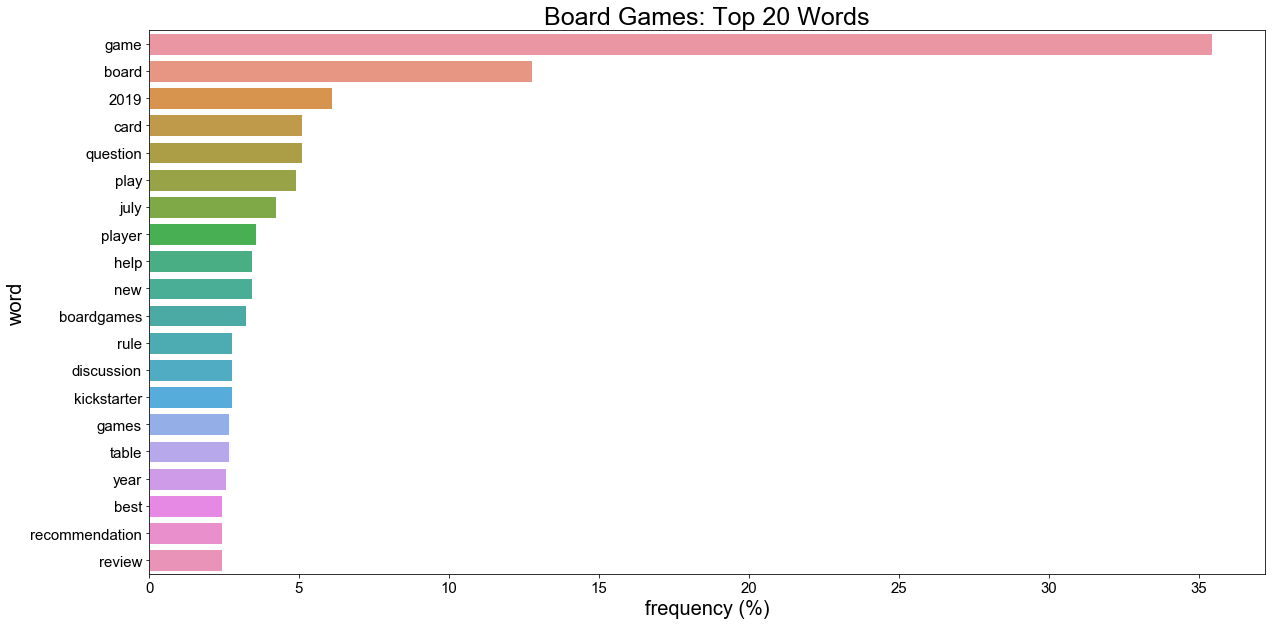

In [28]:
plt.figure(figsize=(20,10))
plt.title('Board Games: Top 20 Words',fontsize=25)

sns.set_style("whitegrid")
sns.barplot(data=df_top_a.head(20),x='freq',y='word',orient='h')

plt.xlabel('frequency (%)',fontsize=20)
plt.ylabel('word',fontsize=20)
plt.tick_params(labelsize=15)

#print('Game and Games are among the top 20 words for board games.')
#print('These words have the same context and should be lemmatized for the classification models.')

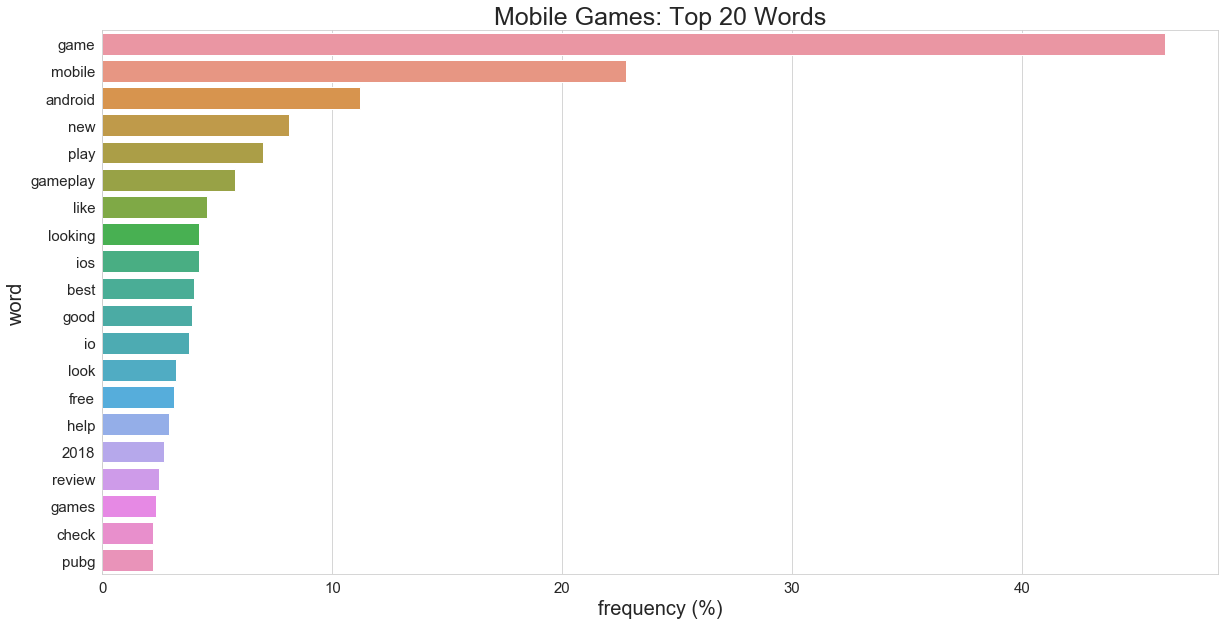

In [29]:
plt.figure(figsize=(20,10))
plt.title('Mobile Games: Top 20 Words',fontsize=25)

sns.set_style("whitegrid")
sns.barplot(data=df_top_b.head(20),x='freq',y='word',orient='h')

plt.xlabel('frequency (%)',fontsize=20)
plt.ylabel('word',fontsize=20)
plt.tick_params(labelsize=15)

#print('Interesting to note that 2018 is among the top 20 words for mobile games.')

Venn Diagram below shows the top 20 words for both subreddits.
There are 7 common words as expected for the subreddits given their similarities.


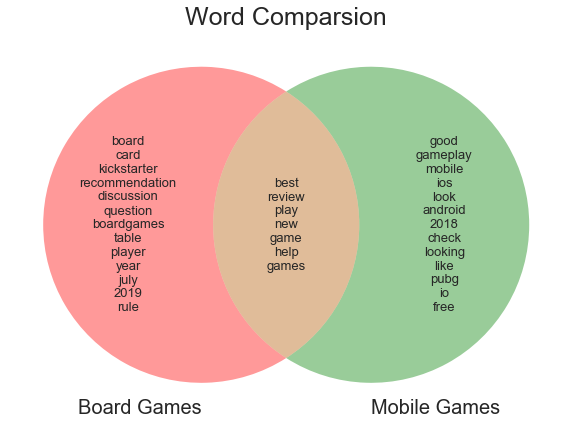

In [30]:
plt.figure(figsize=(10,10))
plt.title('Word Comparsion',fontsize=25)

set_a = set(df_top_a['word'][:20])
set_b = set(df_top_b['word'][:20])

venn = venn2([set_a,set_b],set_labels=['Board Games','Mobile Games'])

venn.get_label_by_id('100').set_text('\n'.join(map(str,set_a-set_b)))
venn.get_label_by_id('110').set_text('\n'.join(map(str,set_a&set_b)))
venn.get_label_by_id('010').set_text('\n'.join(map(str,set_b-set_a)))

venn.get_label_by_id('A').set_size(20)
venn.get_label_by_id('B').set_size(20)
venn.get_label_by_id('100').set_size(13)
venn.get_label_by_id('110').set_size(13)
venn.get_label_by_id('010').set_size(13)

print('Venn Diagram below shows the top 20 words for both subreddits.')
print('There are 7 common words as expected for the subreddits given their similarities.')

### Create Feature Matrix and Target

In [31]:
# create df by appending df_a and df_b

df = df.append(df_a)
df = df.append(df_b)

df.reset_index(drop=True,inplace=True)

In [32]:
# create target (use one hot encoding)

df['is_a'] = 0
df['is_a'].iloc[0:len(df_a)] = 1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [33]:
# create X (feature matrix) and y (target)

X = df[['title']]
y = df['is_a'].values

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,test_size=0.3,stratify=y,random_state=3050)

In [34]:
# check train and test data

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1260, 1)
(540, 1)
(1260,)
(540,)


In [35]:
print('baseline score:',y_test.mean())

baseline score: 0.5


### Logistic Regression Model

In [36]:
# create baseline model with CountVectorizer

cvec_0 = CountVectorizer()
cvec_0.fit(X_train['title'])

len_features = len(cvec_0.get_feature_names())
print(len_features)

X_train_cv_0 = pd.DataFrame(cvec_0.transform(X_train['title']).todense(),columns=cvec_0.get_feature_names())
X_test_cv_0 = pd.DataFrame(cvec_0.transform(X_test['title']).todense(),columns=cvec_0.get_feature_names())

# use with Logistic Regression

lr_model_0 = LogisticRegression()
lr_model_0.fit(X_train_cv_0,y_train)

score = lr_model_0.score(X_test_cv_0, y_test)
print(score)

2858


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8703703703703703


In [37]:
# create another model with CountVectorizer

cvec_1 = CountVectorizer(stop_words='english',ngram_range=(1,2))
cvec_1.fit(X_train['title'])

len_features = len(cvec_1.get_feature_names())
print(len_features)

X_train_cv_1 = pd.DataFrame(cvec_1.transform(X_train['title']).todense(),columns=cvec_1.get_feature_names())
X_test_cv_1 = pd.DataFrame(cvec_1.transform(X_test['title']).todense(),columns=cvec_1.get_feature_names())

# use with LogisticRegression

lr_model_1 = LogisticRegression()
lr_model_1.fit(X_train_cv_1,y_train)

score = lr_model_1.score(X_test_cv_1, y_test)
print(score)

print('baseline model (lr_model_0) has better accuracy than 2nd model (lr_model_1)')

7659


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8703703703703703
baseline model (lr_model_0) has better accuracy than 2nd model (lr_model_1)


### Bayes Classifer

In [67]:
# create baseline model with MultinomialNB model
# use X_train_cv_0, X_test_cv_0, y_train, y_test

mnb = MultinomialNB()

mnb.fit(X_train_cv_0,y_train)
y_pred = mnb.predict(X_test_cv_0)

# score MultinomialNB model

train_score = mnb.score(X_train_cv_0,y_train)
print('train_score:',train_score)

test_score = mnb.score(X_test_cv_0,y_test)
print('test_score:',test_score)
print('')

# create confusion matrix

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("True Positives: %s" % tp)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Negatives: %s" % tn)
print('')

# confusion matrix metrics

accuracy = (tp+tn)/(tp+fp+fn+tn)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)

print('Accuracy:',round(accuracy,3))
print('Sensitivity:',round(sensitivity,3))
print('Specificity:',round(specificity,3))
print('Precision:',round(precision,3))

train_score: 0.976984126984127
test_score: 0.8944444444444445

True Positives: 242
False Positives: 29
False Negatives: 28
True Negatives: 241

Accuracy: 0.894
Sensitivity: 0.896
Specificity: 0.893
Precision: 0.893


In [68]:
# create another model with MultinomialNB model
# use X_train_cv_1, X_test_cv_1, y_train, y_test

mnb = MultinomialNB()

mnb.fit(X_train_cv_1,y_train)
y_pred = mnb.predict(X_test_cv_1)

# score MultinomialNB model

train_score = mnb.score(X_train_cv_1,y_train)
print('train_score:',train_score)

test_score = mnb.score(X_test_cv_1,y_test)
print('test_score:',test_score)
print('')

# create confusion matrix

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("True Positives: %s" % tp)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Negatives: %s" % tn)
print('')

# confusion matrix metrics

accuracy = (tp+tn)/(tp+fp+fn+tn)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)

print('Accuracy:',round(accuracy,3))
print('Sensitivity:',round(sensitivity,3))
print('Specificity:',round(specificity,3))
print('Precision:',round(precision,3))

train_score: 0.9880952380952381
test_score: 0.8925925925925926

True Positives: 235
False Positives: 23
False Negatives: 35
True Negatives: 247

Accuracy: 0.893
Sensitivity: 0.87
Specificity: 0.915
Precision: 0.911


### Models by Pipeline

In [40]:
# TfidfVectorizer with LogisticRegression

model = make_pipeline(TfidfVectorizer(stop_words='english',
                                      sublinear_tf=True,
                                      max_df=0.5,
                                      max_features=1000,
                                     ngram_range=(1,2)),
                      LogisticRegression(),
                      )

model.fit(X_train['title'], y_train)
y_pred = model.predict(X_test['title'])

print('accuracy_score',accuracy_score(y_test, y_pred))
print("Number of features:", len(model.steps[0][1].get_feature_names()))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy_score 0.8481481481481481
Number of features: 1000


In [41]:
# TfidfVectorizer with MultinomialNB

model = make_pipeline(TfidfVectorizer(stop_words='english',
                                      sublinear_tf=True,
                                      max_df=0.5,
                                      max_features=1000,
                                      ngram_range=(1,2)),
                      MultinomialNB()
                      )

model.fit(X_train['title'], y_train)
y_pred = model.predict(X_test['title'])

print('accuracy_score',accuracy_score(y_test, y_pred))
print("Number of features:", len(model.steps[0][1].get_feature_names()))

accuracy_score 0.8666666666666667
Number of features: 1000


### GridSearch Approach

### Sentiment Analysis

In [42]:
# using SentimentIntensityAnalyser to find any correlations between reddit score and compound

# reddit score:
# the difference between upvotes and downvotes

# compound: 
# a metric that calculates the sum of all the lexicon ratings

# normalized between -1 (most extreme negative) and +1 (most extreme positive).

In [43]:
# drop rows with no content

df_a_sen = df_a.copy()
df_b_sen = df_b.copy()

print(len(df_a_sen))
print(len(df_b_sen))
print('')

df_a_sen['selftext'].replace('',np.nan,inplace=True)
df_b_sen['selftext'].replace('',np.nan,inplace=True)

df_a_sen.dropna(subset=['selftext'],inplace=True)
df_b_sen.dropna(subset=['selftext'],inplace=True)

print(len(df_a_sen))
print(len(df_b_sen))

900
900

797
332


In [44]:
# store sentiment scores in df_a_sen

cols = ['neg','neu','pos','compound']
for col in cols:
    df_a_sen[col] = 0.0

for idx,row in df_a_sen.iterrows():
    
    doc = nlp(row['selftext'])
    polar_score = doc._.polarity_scores

    df_a_sen.at[idx,'neg'] = polar_score['neg']
    df_a_sen.at[idx,'neu'] = polar_score['neu']
    df_a_sen.at[idx,'pos'] = polar_score['pos']
    df_a_sen.at[idx,'compound'] = polar_score['compound']

In [45]:
# store sentiment scores in df_b_sen

cols = ['neg','neu','pos','compound']
for col in cols:
    df_b_sen[col] = 0.0

for idx,row in df_b_sen.iterrows():
    
    doc = nlp(row['selftext'])
    polar_score = doc._.polarity_scores

    df_b_sen.at[idx,'neg'] = polar_score['neg']
    df_b_sen.at[idx,'neu'] = polar_score['neu']
    df_b_sen.at[idx,'pos'] = polar_score['pos']
    df_b_sen.at[idx,'compound'] = polar_score['compound']

In [46]:
df_a_sen.head()

,name,title,score,selftext,neg,neu,pos,compound
0,t3_ccwwo2,what player mat look like after lamination,12,searched this sub and google for image of the ...,0.034,0.816,0.150,0.9052
1,t3_ccppxz,anyone playing in downtown toronto?,69,i've built up a small game collection lately -...,0.044,0.905,0.051,0.0747
3,t3_ccwwjl,pandemic legacy s1 *september spoilers*,8,just want to make sure cause this seems weird....,0.124,0.798,0.078,-0.3151
4,t3_cctvi9,rumbleslam is the best game i almost never hea...,17,80's and 90's wrestling reference really shine...,0.000,0.768,0.232,0.9244
5,t3_ccvrtl,about to play eldritch horror for the first ti...,11,i'm buying eldritch horror tonight and i'm hop...,0.103,0.586,0.310,0.9183


In [47]:
df_b_sen.head()

,name,title,score,selftext,neg,neu,pos,compound
0,t3_bbdq7o,"age of z, recruiting",1,i'm looking for player who play the game age o...,0.000,0.765,0.235,0.5574
1,t3_bbb1np,there wa a java game...,1,"i remember playing an old game on my nokia, ab...",0.000,0.848,0.152,0.6124
2,t3_bb4yj9,mmorpg?,1,hi guys! can you suggest some mobile mmorpg? s...,0.000,0.544,0.456,0.9412
4,t3_baqg2e,searching for game to be transplanted from ste...,1,"hi, i am a steam game player with more than 30...",0.000,0.774,0.226,0.9498
6,t3_bamstx,ww2-style boom beach?,2,anyone remember a game on the play store that ...,0.054,0.731,0.215,0.9023


There are more posts with positive than negative sentiments.
The highest reddit score for postive and negative sentiments are 1,700 and 550 respectively (approximated).


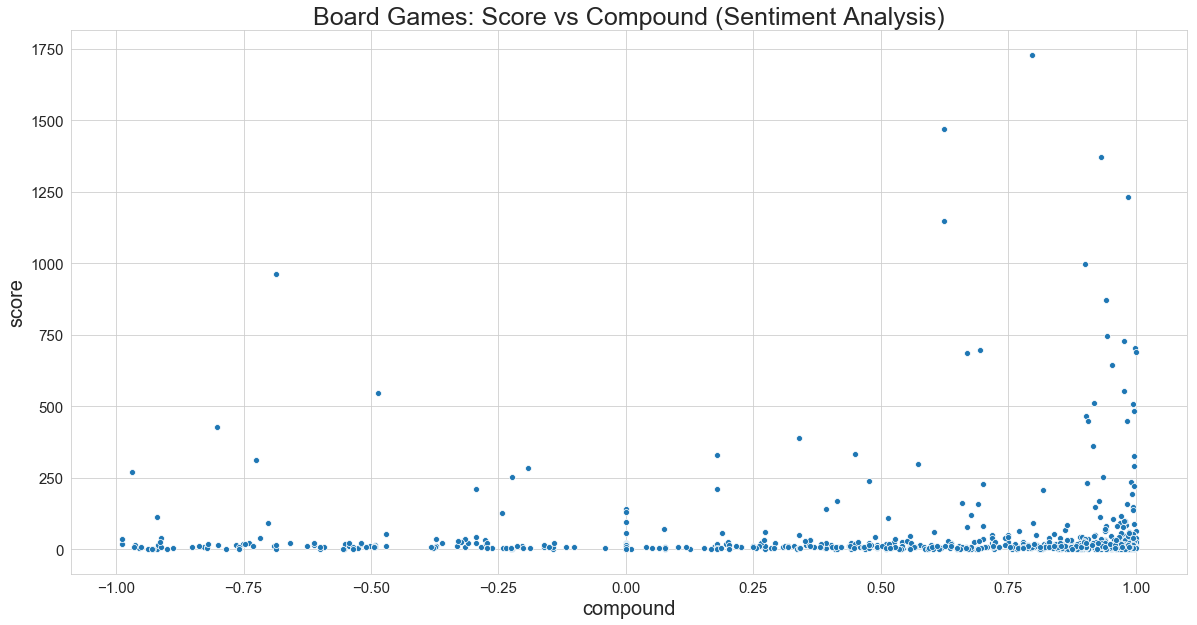

In [48]:
plt.figure(figsize=(20,10))
plt.title('Board Games: Score vs Compound (Sentiment Analysis)',fontsize=25)

sns.set_style("whitegrid")
sns.scatterplot(data=df_a_sen,x='compound',y='score')

plt.xlabel('compound',fontsize=20)
plt.ylabel('score',fontsize=20)
plt.tick_params(labelsize=15)

print('There are more posts with positive than negative sentiments.')
print('The highest reddit score for postive and negative sentiments are 1,700 and 550 respectively (approximated).')

No obvious trends between reddit scores and postive/negative sentiments.
The Mobile Game Subreddit has much lower average reddit scores compared to Board Game Subreddit.
Likely due to much lower membership for Mobile Game Subreddit.
Board Game Subbreddit has 75 times more members than Mobile Game Subreddit.


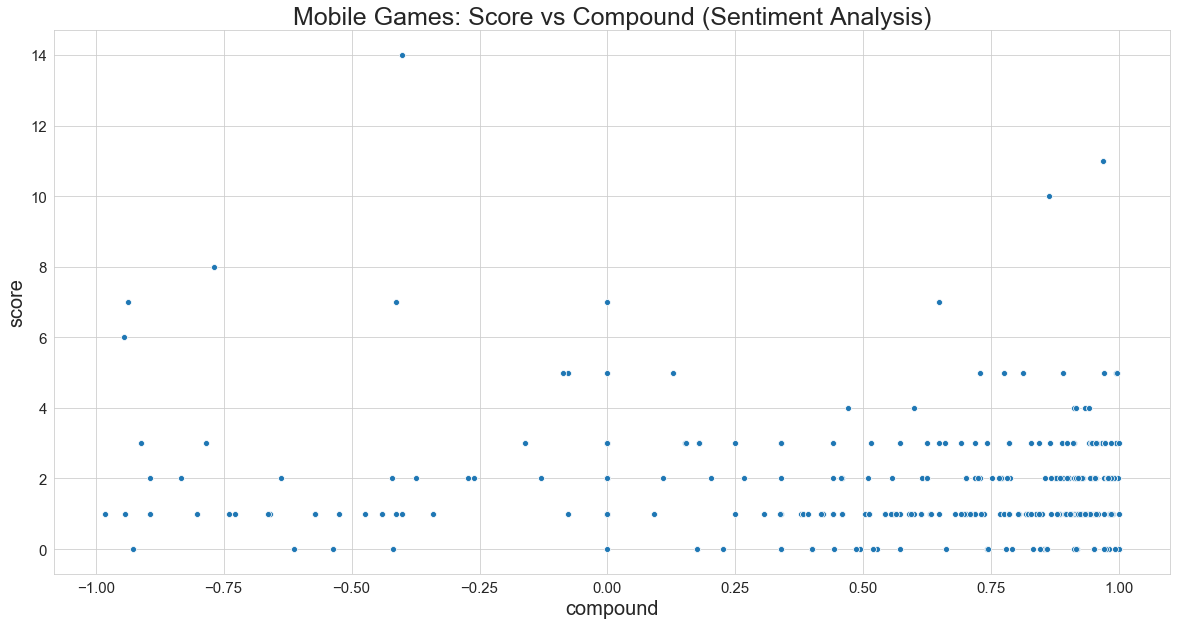

In [49]:
plt.figure(figsize=(20,10))
plt.title('Mobile Games: Score vs Compound (Sentiment Analysis)',fontsize=25)

sns.set_style("whitegrid")
sns.scatterplot(data=df_b_sen,x='compound',y='score')

plt.xlabel('compound',fontsize=20)
plt.ylabel('score',fontsize=20)
plt.tick_params(labelsize=15)

print('No obvious trends between reddit scores and postive/negative sentiments.')
print('The Mobile Game Subreddit has much lower average reddit scores compared to Board Game Subreddit.')
print('Likely due to much lower membership for Mobile Game Subreddit.')
print('Board Game Subbreddit has 75 times more members than Mobile Game Subreddit.')

In [50]:
# create bins to plot histogram later

bins = np.arange(-1,1.1,0.25)
df_a_sen['binned'] = pd.cut(df_a_sen['compound'], bins=bins)

df_a_sen['score'] = df_a_sen['score'].astype(int)
a_sen_bin = df_a_sen.groupby(df_a_sen['binned'])['score'].mean()
df_a_sen_bin = pd.DataFrame(a_sen_bin)

In [51]:
# create bins to plot histogram later

df_b_sen['binned'] = pd.cut(df_b_sen['compound'], bins=bins)

df_b_sen['score'] = df_b_sen['score'].astype(int)
b_sen_bin = df_b_sen.groupby(df_b_sen['binned'])['score'].mean()
df_b_sen_bin = pd.DataFrame(b_sen_bin)

postive correlation for between average score and postive sentiments (compound 0.0 to 1.0).
no trend observed for negative sentiments (compound -1.0 to 0)


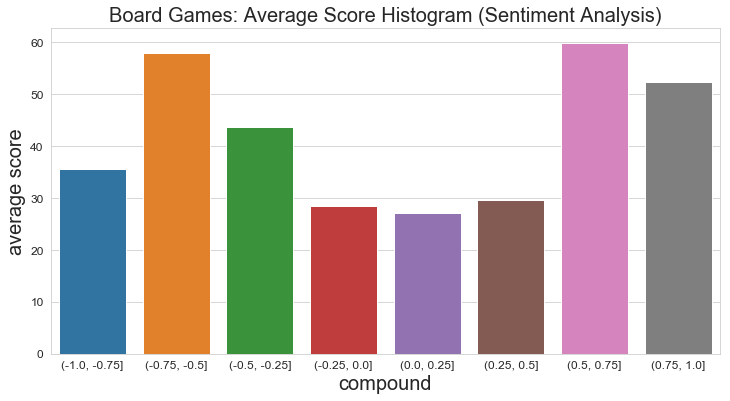

In [52]:
plt.figure(figsize=(12,6))
plt.title('Board Games: Average Score Histogram (Sentiment Analysis)',fontsize=20)

sns.set_style("whitegrid")
sns.barplot(data=df_a_sen_bin,x=df_a_sen_bin.index,y=df_a_sen_bin['score'].values)

plt.xlabel('compound',fontsize=20)
plt.ylabel('average score',fontsize=20)
plt.tick_params(labelsize=12)

print('postive correlation for between average score and postive sentiments (compound 0.0 to 1.0).')
print('no trend observed for negative sentiments (compound -1.0 to 0)')

Highest average score is 3.0 for negative sentimen. Observed for compound -0.5 to -0.25.
Highest average score is 2.0 for positive sentiment. Observed for compound 0.0 to 0.25.
The difference in average score (between negative and positive sentiment) is small i.e. difference of only 1.0.


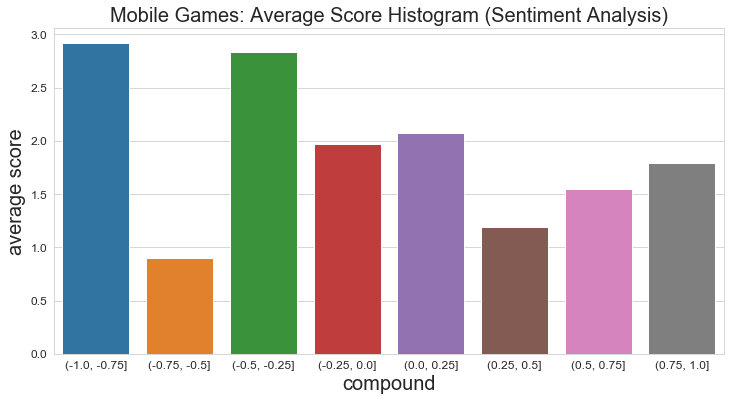

In [53]:
plt.figure(figsize=(12,6))
plt.title('Mobile Games: Average Score Histogram (Sentiment Analysis)',fontsize=20)

sns.set_style("whitegrid")
sns.barplot(data=df_b_sen_bin,x=df_b_sen_bin.index,y=df_b_sen_bin['score'].values)

plt.xlabel('compound',fontsize=20)
plt.ylabel('average score',fontsize=20)
plt.tick_params(labelsize=12)

print('Highest average score is 3.0 for negative sentimen. Observed for compound -0.5 to -0.25.')
print('Highest average score is 2.0 for positive sentiment. Observed for compound 0.0 to 0.25.')
print('The difference in average score (between negative and positive sentiment) is small i.e. difference of only 1.0.')

### Output Model Predictions

In [54]:
# output to csv

#timestamp = dt.datetime.now()
#timestamp = timestamp.strftime(" %Y_%m_%d %H_%M_%S ")
    
# contains selected columns for feature matrix
#df_cols.to_csv(output_path + 'columns' + timestamp + '.csv')

### Descriptive and Inferential Statistics

In [55]:
df_top_a_cv = df_a_cv[list(set_a)]
df_top_b_cv = df_b_cv[list(set_b)]

# for each post, count number of occurances (from top words list)
a_cv_has_top = df_top_a_cv.sum(axis=1)
b_cv_has_top = df_top_b_cv.sum(axis=1)

In [56]:
# create df_a_cv_has_top

df_a_cv_has_top= a_cv_has_top.value_counts().to_frame()

df_a_cv_has_top['occurances'] = df_a_cv_has_top.index

df_a_cv_has_top.reset_index(drop=True, inplace=True)

df_a_cv_has_top.rename(columns={0: "num_posts"},inplace=True)
df_a_cv_has_top['freq'] = df_a_cv_has_top["num_posts"] / len(df_a) * 100
cols = ['occurances','num_posts','freq']
df_a_cv_has_top = df_a_cv_has_top[cols]
df_a_cv_has_top.sort_values(by='occurances',inplace=True)

In [57]:
# create df_b_cv_has_top

df_b_cv_has_top= b_cv_has_top.value_counts().to_frame()

df_b_cv_has_top['occurances'] = df_b_cv_has_top.index

df_b_cv_has_top.reset_index(drop=True, inplace=True)

df_b_cv_has_top.rename(columns={0: "num_posts"},inplace=True)
df_b_cv_has_top['freq'] = df_b_cv_has_top["num_posts"] / len(df_b) * 100
cols = ['occurances','num_posts','freq']
df_b_cv_has_top = df_b_cv_has_top[cols]
df_b_cv_has_top.sort_values(by='occurances',inplace=True)

The barplot shows 42% of all post titles does not contain any of the top 20 words.
Interesting to note there is 7 occurances of top words in 2% of all post titles.


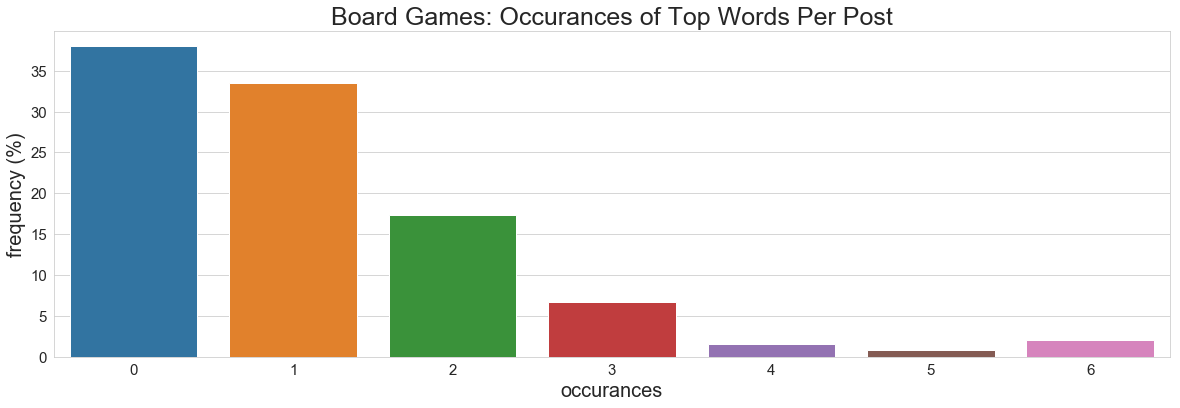

In [58]:
plt.figure(figsize=(20,6))
plt.title('Board Games: Occurances of Top Words Per Post',fontsize=25)

sns.set_style("whitegrid")

sns.barplot(data=df_a_cv_has_top,x='occurances',y='freq')

plt.xlabel('occurances',fontsize=20)
plt.ylabel('frequency (%)',fontsize=20)
plt.tick_params(labelsize=15)

print('The barplot shows 42% of all post titles does not contain any of the top 20 words.')
print('Interesting to note there is 7 occurances of top words in 2% of all post titles.')

73% of all post titles contain at least 1 occurance of top 20 words.
Frequency and occurances (of top words per post) has negative correlations.
A max of 8 occurances of top words per post title is observed.


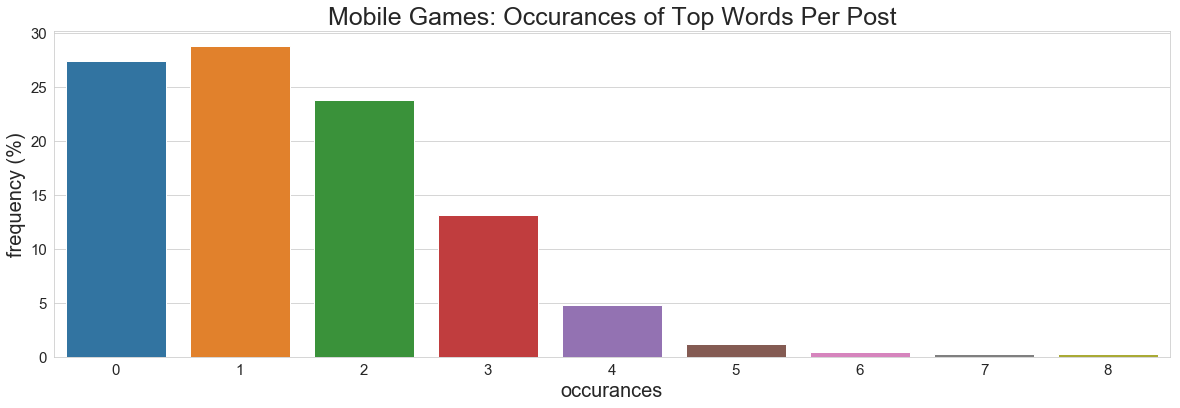

In [59]:
plt.figure(figsize=(20,6))
plt.title('Mobile Games: Occurances of Top Words Per Post',fontsize=25)

sns.set_style("whitegrid")

sns.barplot(data=df_b_cv_has_top,x='occurances',y='freq')

plt.xlabel('occurances',fontsize=20)
plt.ylabel('frequency (%)',fontsize=20)
plt.tick_params(labelsize=15)

print('73% of all post titles contain at least 1 occurance of top 20 words.')
print('Frequency and occurances (of top words per post) has negative correlations.')
print('A max of 8 occurances of top words per post title is observed.')

In [60]:
mask_a_top = a_cv_has_top == a_cv_has_top.max()
a_title = df_a[mask_a_top]['title']

print('Print the titles with 8 occurances of top 20 words for Board Games.')
print('The 8 occurances were due to a daily posts in the Subreddit.')
print('----------------------------------------------------------------------------')

for title in a_title:
    print(title)

Print the titles with 8 occurances of top 20 words for Board Games.
The 8 occurances were due to a daily posts in the Subreddit.
----------------------------------------------------------------------------
/r/boardgames daily discussion and game recommendation (july 14, 2019)
/r/boardgames daily discussion and game recommendation (july 15, 2019)
/r/boardgames daily discussion and game recommendation (july 16, 2019)
/r/boardgames daily discussion and game recommendation (july 17, 2019)
/r/boardgames daily discussion and game recommendation (july 18, 2019)
/r/boardgames daily discussion and game recommendation (july 19, 2019)
/r/boardgames daily discussion and game recommendation (july 01, 2019)
/r/boardgames daily discussion and game recommendation (july 02, 2019)
/r/boardgames daily discussion and game recommendation (july 03, 2019)
/r/boardgames daily discussion and game recommendation (july 04, 2019)
/r/boardgames daily discussion and game recommendation (july 05, 2019)
/r/boardgames

In [61]:
mask_a_top = b_cv_has_top == b_cv_has_top.max()
b_title = df_b[mask_a_top]['title']

print('Print the titles with 8 occurances of top 20 words for Mobile Games.')
print('These posts have long titles but no particular trend is observed.')
print('----------------------------------------------------------------------------')

for title in b_title:
    print('')
    print(title)

Print the titles with 8 occurances of top 20 words for Mobile Games.
These posts have long titles but no particular trend is observed.
----------------------------------------------------------------------------

[android] looking for game that are a lot like game of sultans. good or bad i'll try any of them a long a it's like that type of game. so don't be afraid to send them!

what is a good and fun mobile game that doesnt look like it made for a nine year old? sometimes i feel so stupid playing game like angry bird or temple run in the train. (still love the game though)


### Executive Summary

In [62]:
# Link Here